# FX MMN paper

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import scipy.stats as sstat
import scipy.signal as ssig
import h5py
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
import re
import ephys_unit_analysis as ena
import fnmatch
# from PyPDF2 import PdfFileMerger, PdfFileReader
import seaborn as sns
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

%load_ext autoreload
%autoreload 2
# pal=sns.blend_palette(["black", "crimson"], 2)
sns.despine()
# current_palette = sns.color_palette("colorblind", 10)
# sns.set_palette(current_palette)

# for publication quality plots, not bar graphs, use this: 
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette(pal)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()



#%matplotlib notebook

In [ ]:
pal=sns.blend_palette(["gray","crimson", 'magenta','cyan',  'purple'  ],5)
sns.palplot(pal)
sns.set_palette(pal)
groups = {'479': 'wt', '480': 'fx', '481':'fx', '482': 'fx', '483': 'wt', '484': 'wt', '485':'wt', '486':'fx', 
          '013': 'wt', '014': 'fx', '016': 'fx', '017': 'wt', '018': 'fx', '019': 'wt', '020': 'wt', '022': 'fx',
         '023': 'wt', '024': 'fx', '025': 'fx', '026': 'fx', '027': 'fx', '028': 'fx', '029': 'wt', '030': 'fx', '031': 'fx', '032': 'fx', 
          '033': 'fx' , '034': 'fx', '035': 'wt', 'W00': 'wt', 'W01': 'wt',
 'W02': 'wt', 'W03': 'wt', 'W04': 'wt', 'W05':'wt'}

In [ ]:
probe = '64DB'
oddball = ena.get_paradigm('glob_oddball')
omission = ena.get_paradigm('exp_omission')
sf_tuning = ena.get_paradigm('sf-tuning')
d_odd_stim = {}
d_odd_opto = {}
d_tun_stim = {}
d_tun_opto = {}
oddball_opto_seq = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0])


oddball_opto_idx = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

sf_tuning_opto_seq = np.array([4, 4, 3, 5, 0, 5, 3, 1, 2, 3, 5, 3, 0, 1, 0, 3, 2, 4, 5, 5, 0, 0,
       5, 1, 3, 4, 4, 4, 5, 1, 2, 1, 4, 5, 3, 1, 4, 0, 0, 3, 0, 2, 0, 1,
       3, 1, 0, 5, 5, 2, 1, 1, 1, 4, 4, 1, 5, 0, 5, 3, 1, 3, 0, 3, 0, 3,
       3, 2, 4, 1, 5, 2, 5, 3, 5, 5, 0, 0, 3, 5, 4, 3, 0, 2, 1, 5, 0, 4,
       5, 0, 3, 2, 3, 4, 5, 0, 4, 0, 2, 2, 4, 3, 5, 4, 1, 2, 1, 1, 2, 3,
       2, 2, 0, 3, 0, 1, 2, 5, 2, 3, 0, 1, 3, 4, 0, 2, 2, 2, 0, 5, 4, 2,
       3, 2, 3, 3, 4, 0, 4, 3, 3, 1, 5, 2, 0, 2, 5, 3, 2, 5, 5, 4, 1, 3,
       4, 3, 1, 0, 2, 2, 5, 4, 1, 3, 1, 1, 4, 4, 1, 5, 3, 3, 5, 4, 3, 3,
       1, 0, 2, 4, 1, 5, 1, 3, 5, 1, 1, 1, 4, 2, 3, 0, 0, 1, 1, 1, 3, 2,
       1, 4, 4, 3, 2, 3, 4, 5, 4, 5, 3, 1, 2, 1, 2, 2, 0, 5, 0, 2, 4, 4,
       2, 5, 4, 0, 5, 0, 4, 4, 3, 0, 2, 5, 5, 3, 0, 4, 1, 3, 0, 0, 1, 2,
       2, 5, 1, 4, 3, 0, 0, 5, 4, 4, 1, 0, 4, 2, 2, 4, 5, 1, 5, 0, 5, 2,
       2, 0, 2, 2, 2, 0, 1, 4, 4, 1, 5, 4, 4, 0, 2, 5, 5, 0, 0, 1, 3, 0,
       1, 3, 5, 5, 4, 1, 0, 2, 2, 2, 3, 5, 1, 4])

sf_tuning_opto_idx = np.array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0])

for i, v in enumerate(oddball_opto_seq):
    d_odd_stim[i] = v 
for i, v in enumerate(oddball_opto_idx):
    d_odd_opto[i] = v 
for i, v in enumerate(sf_tuning_opto_seq):
    d_tun_stim[i] = v 
for i, v in enumerate(sf_tuning_opto_idx):
    d_tun_opto[i] = v 

channel_groups = ena.get_channel_depth(probe)
odd_idx = np.where(np.array(oddball.values())==9)
omis_idx = np.where(np.array(omission.values())==2)
ch_map = ena.get_channel_depth(probe)

In [ ]:
colors_stim = ['gray', 'crimson', 'green']
colors_group = ['k', 'coral']

In [ ]:
matches = [] # list of experiment folders
source_folder = r"U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn-LMopto\left1"
for root, dirnames, filenames in os.walk(source_folder):
    for dirname in fnmatch.filter(dirnames, '*conc'):
        if 'atch' in dirname or 'bad' in dirname:
            continue
        matches.append(os.path.join(root, dirname)) 
print matches[:5]
print len(matches)

In [ ]:
for path in matches[:]:

    et = path.split('\\')[-2].split()[0]
    print et

## Generate psth

In [ ]:
#Receptive field mapping
ls_psth = []
ls_spikes = []
ls_tmt = []

for path in matches[:]:
    df = 0
    if 'bad' in path or 'opto4' in path:
        continue
    print path
    et = path.split('\\')[-2].split()[0]
    side = 'left-1'
    path_cluster_groups = os.path.join(path, 'cluster_groups.csv')
    cluster_groups = pd.read_csv(path_cluster_groups, sep = '\t')
    # good_units = cluster_groups[cluster_groups.group != 'noise'].cluster_id.values
    noise_units = cluster_groups[cluster_groups['group'] == 'noise'].cluster_id.values
    spike_times = np.load(os.path.join(path, 'spike_times.npy'))
    spike_clusters = np.load(os.path.join(path, 'spike_clusters.npy'))
    templates = np.load(os.path.join(path, 'templates.npy'))
    spike_templates = np.load(os.path.join(path, 'spike_templates.npy'))
    df = pd.DataFrame({'times':spike_times.flatten()/30000.0, 
                       'unit_id':spike_clusters.flatten(), 
                       'templates':spike_templates.flatten() })

    df = df[~df.unit_id.isin(noise_units)]
    df.loc[:,'et'] = et
    df.loc[:,'side'] = side
    df.loc[:,'cluster_id'] = df.loc[:,'unit_id'].astype('str') + 'et' + df.loc[:,'et'] + df.loc[:,'side']
    df.loc[:,'path'] = path
#     df.loc[:,'trial_n'] = df.loc[:,'times']//1.0

    ls_spikes.append(df)

# df_tmt = pd.concat(ls_tmt)
df_spikes = pd.concat(ls_spikes)

# master_kic.head()

In [ ]:
df_spikes.head()

In [ ]:
df_spikes.to_pickle('fx_var-odd_spikes_12-18-18.pkl')

In [ ]:
tmp = df_spikes

df1 = tmp[(tmp.loc[:, 'times'] < 20)] #sf-tuning
df1.loc[:, 'trial_n'] = df1.loc[:, 'times'] //1.0
df1.loc[:,'stim1'] = ['G-1']

df2 = tmp[(tmp.loc[:, 'times'] > 20) & (tmp.loc[:, 'times'] < 40)] #sf-tuning
df2.times = df2.times - 20
df2.loc[:, 'trial_n'] = df2.loc[:, 'times'] //1.0
df2.loc[:,'stim1'] = ['G-1-opto-g01']

# df3 = tmp[(tmp.loc[:, 'times'] > 40) & (tmp.loc[:, 'times'] < 60)] #sf-tuning
# df3.times = df3.times - 40
# df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
# df3.loc[:,'stim1'] = ['LM-G-1-opto-g05']

# df4 = tmp[(tmp.loc[:, 'times'] > 60) & (tmp.loc[:, 'times'] < 80)] #sf-tuning
# df4.times = df4.times - 60
# df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1.0
# df4.loc[:,'stim1'] = ['LM-G-1-opto-g075']

df3 = tmp[(tmp.loc[:, 'times'] > 40) & (tmp.loc[:, 'times'] < 340)] #sf-tuning
df3.times = df3.times - 40
df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1
df3.loc[:,'stim1'] = df3.loc[:, 'trial_n'].map(d_tun_stim)
df3.loc[:,'opto'] = df3.loc[:, 'trial_n'].map(d_tun_opto)

df4 = tmp[(tmp.loc[:, 'times'] > 340)] #sf-nov-odd
df4.times = df4.times - 340
df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1
df4.loc[:,'stim1'] = df4.loc[:, 'trial_n'].map(d_odd_stim)
df4.loc[:,'opto'] = df4.loc[:, 'trial_n'].map(d_odd_opto)

# df4 = df_spikes[(df_spikes.loc[:, 'times'] >= 320) ] #sf-nov-odd
# df4.times = df4.times - 320
# df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1.0
# df4.loc[:,'stim1'] = df4.loc[:, 'trial_n'].map(omission)

# df4 = df_spikes[ (df_spikes.loc[:, 'times'] > 320) & (df_spikes.loc[:, 'times'] < 360) ] # opto ramp
# df4.loc[:, 'times'] = df4.loc[:, 'times'] - 320
# df4['stim1'] = 'ramp_on'
# df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //2.0

# df5 = df_spikes[ (df_spikes.loc[:, 'times'] > 360) ] # opto chirp
# df5.loc[:, 'times'] = df5.loc[:, 'times'] - 320
# df5['stim1'] = 'chirp'
# df5.loc[:, 'trial_n'] = df5.loc[:, 'times'] //8.0


In [ ]:
df3.trial_n.unique()

In [ ]:
d_psth = {}

In [ ]:
#generate psth for vmmn data
trial_length = 1.0
th_bin = 0.01
trials_number = 25.0
ls_psth = []
ls_tmt = []

data = df4
# data['opto'] = 1
paradigm = 'sf-oddball-LMopto-g01'
stim_type = 'ctr'

for opto in data.opto.unique():
    tmp = data[data.opto == opto]
    for idx_stim1, stim1 in enumerate(sorted(tmp['stim1'].unique())):
        print stim1
        trials_to_incl = np.arange(400)
        tmp2 = tmp[ (tmp.stim1 == stim1)]
        if 'odd' in paradigm or 'omis' in paradigm:
            odd_trials = tmp[tmp.stim1 == 1].trial_n.unique()
            if stim1 == 1:
                stim_type = 'dev'
                idx_stim1 = 1
            elif stim1 == 0:
                stim_type = 'std'
                trials_to_incl = odd_trials - 1 # pre oddball trials
                idx_stim1 = 0
            elif stim1 == 40:
                stim_type = 'omis'
                trials_to_incl = omis_idx[0] - 1 # pre oddball trials
                idx_stim1 = 0
        for unit in tmp2['cluster_id'].unique():
            tmp3 = tmp2[(tmp2.cluster_id == unit)]
            tmp3 = tmp3[(tmp3.trial_n.isin(trials_to_incl))] 
#             print tmp3.shape
            if tmp3.shape[0] < 1:
                continue
            et = tmp3.et.unique()[0]
            side = tmp3.side.unique()[0]
            path = tmp3.path.unique()[0]
            try:
                tmt, depth, ch_idx = ena.ksort_get_tmt(tmp3, unit, templates, channel_groups)
            except:
                depth = np.nan
            cuid =  str(unit) + 'et' + str(et) + str(stim1) + str(paradigm)
            
            df = ena.getRaster_kilosort(tmp3, unit, trial_length) 
            # check the reliability of the neuron, spike in 0.8 of trials
            if df.trial.unique().size < 0.8*trials_number:
                continue
            h, ttr = ena.PSTH(df.times, th_bin, trial_length, trials_number) # all times rescaled to 0-4 this is why trias number 1.0
            zscore = sstat.mstats.zscore(h)
            mean = np.mean(h[:30])
            std = np.std(h[:30])
            if mean==0:
                std=1
            ztc = (h - mean)/std

            df_psth_tmp = pd.DataFrame({     'times':ttr,    'Hz':h,      'cuid': cuid, 'depth':depth,  
                                        'path': path, 'stim1': stim_type + str(stim1), 'side': side,
                               'abs_times': idx_stim1*trial_length+ttr, 'paradigm':paradigm, 'opto': opto,
                                    'zscore':zscore, 'ztc':ztc,  'et': et, 'cluster_id': unit  })

            ls_psth.append(df_psth_tmp)
#         df_tmt_tmp = pd.DataFrame({'tmt':tmt,  'cluster_id' : unit,  'depth': depth, 'path': path })
#         ls_tmt.append(df_tmt_tmp)
#     break
d_psth[paradigm] = pd.concat(ls_psth)
# df_tmt = pd.concat(ls_tmt)

In [ ]:
tmp3.templates.unique()

In [ ]:
print d_psth[paradigm].shape
print d_psth[paradigm].stim1.unique()
print d_psth[paradigm].cluster_id.unique().size

In [ ]:
df_vmmn2 = pd.concat(d_psth.values()).reset_index(drop = True)

In [ ]:
df_vmmn['group'] =  df_vmmn.et.map(groups)
print df_vmmn2['group'].unique()

In [ ]:
df_vmmn2.groupby([ 'et', 'side']).path.unique()

In [ ]:
the_sine[0]

In [ ]:
df_vmmn = df_vmmn.append(df_vmmn2)

In [ ]:
path = r"U:\Data_Analysis\pak6\Analysis of units\FX mmn paper\fx-mmn-paper_master_spikes.pkl"
df_spikes = pd.read_pickle(path)
path = r"U:\Data_Analysis\pak6\Analysis of units\FX mmn paper\fx-mmn-paper_master_tmt.pkl"
df_tmt = pd.read_pickle(path)
path = r"U:\Data_Analysis\pak6\Analysis of units\FX mmn paper\fx-mmn-paper_master_psth.pkl"
df_vmmn = pd.read_pickle(path)

In [ ]:
df_vmmn.groupby(['group', 'et', 'side']).path.unique()

In [ ]:
# d_psth['sf_tuning'].loc[:, 'times'] = d_psth['sf_tuning'].loc[:, 'times'] - 0.04
d_psth['G-1-LMopto-g01'].loc[:, 'abs_times'] = d_psth['G-1-LMopto-g01'].loc[:, 'abs_times'] + 1

In [ ]:
conditions = [
    (df_vmmn['depth'] <= 600) & (df_vmmn['depth'] >= 400),
    (df_vmmn['depth'] < 400) ,
    (df_vmmn['depth'] > 600)]
choices = ['l4', 'l5/6', 'l2/3']
df_vmmn['layer'] = np.select(conditions, choices)

In [ ]:
df_vmmn.paradigm.unique()

In [ ]:
def get_mmn_idx(data, val = 'Hz' ):
# data = tmp_3km[(tmp_3km.times > 0.1)
#               & (tmp_3km.r_groups < 5)    
#              ]
# val = 'ztc'
# for unit in data.cluster_id.unique()[::50]:
#     tmp = data[(data.cluster_id == unit)]
    
#     tmp.loc[:,'norm_fr'] = tmp.groupby('stim1').Hz.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
    tmp = data
#     rg = tmp.r_groups.unique()[0]

    sf_pref = tmp.pref.unique()[0]

    base_fr = tmp[(tmp.times > 0.05) & (tmp.times < 0.3) & (tmp.stim1.str.contains('dev'))].Hz.values
    dev_fr = tmp[(tmp.times > 0.35) & (tmp.times < 0.6) & (tmp.stim1.str.contains('dev'))].Hz.values
    exc_inh = np.mean(dev_fr) - np.mean(base_fr)
    p_resp = sstat.wilcoxon(dev_fr, base_fr)
    if p_resp[1] < 0.05:
        if exc_inh > 0:
            data['resp_sig'] = 'exc'
        else:
            data['resp_sig'] = 'inh'
    else:
        data['resp_sig'] = 'ns'
        
    base = tmp[(tmp.times > 0)
              & (tmp.times < 0.3)]   
    
    std_base = base[base.stim1.str.contains('std')][val].values
    dev_base = base[base.stim1.str.contains('dev')][val].values
    ctr_base = base[base.stim1 == 'ctr2'][val].values.mean()
    
    tmp2 = tmp[(tmp.times > 0.35)
              & (tmp.times < 0.8)]
    std = tmp2[tmp2.stim1.str.contains('std')][val].values
    dev = tmp2[tmp2.stim1.str.contains('dev')][val].values
    ctr = tmp2[tmp2.stim1 == 'ctr2'][val].values

    std_area = (np.mean(std)) - np.mean(std_base)
    dev_area = (np.mean(dev)) - np.mean(dev_base)
    ctr_area = (np.mean(ctr)) - np.mean(ctr_base)

#     std_area = np.trapz(std - np.mean(std_base))
#     dev_area = np.trapz(dev - np.mean(dev_base))
#     ctr_area = np.trapz(ctr - np.mean(ctr_base))
    
    my_list1 = [std_area, dev_area, ctr_area]
    
    if all(i > 0 for i in my_list1) or all(i < 0 for i in my_list1):
        ssa = (ctr_area - std_area) / (ctr_area + std_area)
        dd = (dev_area - ctr_area) / (dev_area + ctr_area)
        mm = (dev_area - std_area) / (dev_area + std_area)
#         if sf_pref == 'ctr2' or sf_pref == 2:
#             dd = (dev_area - std_area) / (dev_area + std_area)
        
        data.loc[:,'ssa_hz'] = ssa
        data.loc[:,'dd_hz'] = dd
        data.loc[:,'mm_hz'] = mm
        
    if all(i < 0 for i in my_list1):
        data.loc[:, 'resp_sig'] = 'inh'
    return data
#     print ssa, dd
#     plt.plot(tmp[tmp.stim1 == 'ctr2'].times.values, tmp[tmp.stim1 == 'ctr2'].ztc.values,  '.b')
#     plt.plot(tmp[tmp.stim1 == 'dev9'].times.values, tmp[tmp.stim1 == 'dev9'].ztc.values,   '.r')
#     plt.plot(tmp[tmp.stim1 == 'std3'].times.values, tmp[tmp.stim1 == 'std3'].ztc.values,   '.g')
#     plt.axvline(x = 0.3)
#     plt.show()

In [ ]:
# %matplotlib notebook
f, ax = plt.subplots(figsize = (8, 12), facecolor = 'w')
idx = 13
_data = df_vmmn
high_ztc_units = _data[_data.ztc > 400].cluster_id.unique()

# print recs[idx]

data = _data[(_data.paradigm.str.contains('odd') )
              | (_data.stim1.str.contains('ctr2')) 
#                 | (_data.stim1.str.contains('std')) 
#                 & (_data.layer == 'l2/3')
               ]  

# data = _data[ (_data.paradigm.str.contains('odd')) | (_data.stim1.str.contains('ctr2'))]
# data = _data[ (_data.paradigm.str.contains('chirp')) ]
# opto0_units = data[data.opto == 0].cluster_id.unique()
# data = data[(data.layer == 'l5/6')]
data = data[~(data.cluster_id.isin(high_ztc_units))]
# units_include = df_vmmn[df_vmmn.paradigm.str.contains('tuning')].cluster_id.unique()
# data = data[data.cluster_id.isin(units_include)]

data = data.dropna()

# data = data[data.cluster_id.isin(result[result.n_type != 'un'].cluster_id.unique())]
data = data[ (data.times >= 0.05) & (data.times < 0.95)]
# data = data.sort_values(by = ['stim1'])
hm = data.pivot('cluster_id', 'abs_times', 'Hz')
hm = hm.dropna()
good_units = hm.index.values
hm2 = hm.values[ np.argsort(np.mean(hm.values[:,130:180], axis = 1) )]

sns.heatmap(hm2, cmap = 'jet',  annot=False, xticklabels = 200, vmax = 30,
            vmin = 0, robust = True, yticklabels=False, ax = ax, cbar = False )
ax.set(xlabel='', ylabel= hm.shape[0])
# plt.savefig('hm-fx_all_units_std-dev-ctr.png')

In [ ]:
zsc = 'Hz'

fig, ax = plt.subplots(figsize= (12,6))
# data = _data[ (_data.paradigm == 'sf_tuning') & (_data.cluster_id.isin(good_units)) ]
# data = _data[ (_data.paradigm.str.contains('odd')) | (_data.stim1.str.contains('ctr2'))]
data = data[ data.cluster_id.isin(good_units)]

# data = data[data.side.str.contains('left')]
fig_inp = data[(data.times > 0.05) & (data.times < 0.95)]
# target_units = df_odd[df_odd.resp_sig == 'inh'].cluster_id.unique()
# fig_inp = fig_inp[fig_inp.cluster_id.isin(target_units)]
# fig_inp = fig_inp[fig_inp['resp_sig'] == 'ns']
# fig_inp = fig_inp[fig_inp.opto == 0]
# fig_inp['plot_times'] = fig_inp['stim1'].str.split('ctr', expand = True)[1].astype('int')*0.5 + fig_inp['times']
fig_inp = fig_inp.sort_values(by = ['group'], ascending=False)

# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w

sns.lineplot(data=fig_inp, x = 'abs_times', y = zsc, ci = None, 
             palette = colors_group, legend = False, hue = 'group',
      estimator=np.nanmean)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(6):
#     plt.axvspan(0.35 +i, 0.5+i, alpha=0.25, color='gray')
# plt.axvspan(0.9, 1.7,ymin = 0.95, ymax = 1, alpha=0.5, color='green')
# plt.savefig('line-sf_tuning-l23-abs_times.pdf')

In [ ]:
t = np.linspace(0.8, 6, 519)
w = ssig.chirp(t, f0=0, f1=10, t1=6, method='linear')
plt.plot(t, w)
plt.title("Linear Chirp, f(0)=0.5, f(1)=10")
plt.xlabel('t (sec)')

In [ ]:
cond = 'layer'
fig_inp = data[(data.times > 1) & (data.times < 6) 
#              & (data.layer == 'l5/6') 
            ]
# base = gr[(gr.times > 0) & (gr.times < 1)].groupby([ cond, 'group', 'stim1' ,'cluster_id']).mean().reset_index().Hz.values
# fig_inp = gr.groupby('cluster_id').apply(get_auc)

fig_inp = fig_inp.groupby([ cond, 'group'  ,'stim1', 'cluster_id']).mean().reset_index()

# fig_inp.loc[:,'bc_fr'] = fig_inp.Hz - base
# fig_inp = fig_inp[fig_inp.n_type != 'un']
fig_inp = fig_inp.sort_values(by = ['stim1', cond, 'group'], ascending = [False, True, False])
ax = sns.catplot( x = 'layer', y = "Hz", sharey = True,  data= fig_inp,  kind = 'point', ci = 68,  legend = True,
              palette = colors_group, sharex = False, hue = 'group', 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect = 1.2 ,
#                   col_wrap = 2, col = cond,
                )
# plt.savefig('point_fs_odd.pdf')

## SF-tuning

In [ ]:
fig_inp = data[(data.times > 0.35) & (data.times < 0.5) & (data.stim1.str.contains('ctr') )]
fig_inp.cluster_id.unique().size

In [ ]:
# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w')

# data = df_psth[~(df_psth.cluster_id.isin(high_ztc_units))]
data = df_vmmn
df_vmmn['n_type'] = df_vmmn.cluster_id.map(neuron_type)

fig_inp = data[(data.times > 0.35) & (data.times < 0.5) & (data.stim1.str.contains('ctr') )]
fig_inp = fig_inp.groupby([ 'group', 'layer' , 'cluster_id', 'stim1']).mean().reset_index()
tuning_good_units = fig_inp.pivot('cluster_id', 'stim1', 'Hz').dropna().index.values.tolist()

base = data[(data.times > 0) & (data.times < 0.3) & (data.stim1.str.contains('ctr') )].groupby([ 'group',  'layer' ,
                            'cluster_id', 'stim1']).mean().reset_index().dropna().Hz.values
fig_inp.loc[:,'bc_fr'] = fig_inp['Hz'] - base


fig_inp = fig_inp[fig_inp.cluster_id.isin(tuning_good_units)]

fig_inp['norm'] = fig_inp.groupby('cluster_id')['bc_fr'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

fig_inp = fig_inp.sort_values(by = ['stim1', 'group'], ascending= [True, False])
print fig_inp.cluster_id.unique().size
ax = sns.catplot(x="stim1", y = "bc_fr", data = fig_inp,  kind = 'point', ci = 68, hue= 'group',
                    palette = ['k', 'coral'], 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
# plt.savefig('point-tuning-wt-fx-bc-fr-05-08.pdf')

In [ ]:
val = 'bc_fr'
cond = 'stim1'

# for lay in sorted(fig_inp['layer'].unique()):
#     ls = []
#     print lay
for l in sorted(fig_inp[cond].unique()):

    stat_inp = fig_inp[(fig_inp[cond] == l) 
#                        & (fig_inp.layer == lay)
                      ]
    x1 = stat_inp[(stat_inp.group == 'wt')   ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx')   ][val].dropna().values

#     x3 = stat_inp[(stat_inp.group == 'wt') & (stat_inp.n_type == 'fs')][val].dropna().values
#     x4 = stat_inp[(stat_inp.group == 'fx') & (stat_inp.n_type == 'fs')][val].dropna().values

    print '\t', l, len(x1), len(x2)
    wt_mean, wt_sem = np.mean(x1), sstat.sem(x1)
    fx_mean, fx_sem = np.mean(x2), sstat.sem(x2)
#     print 'wt, fs', len(x3) ,np.mean(x3), sstat.sem(x3)
#     print 'fx, fs', len(x4) ,np.mean(x4), sstat.sem(x4)

    x1_x2 = sstat.mannwhitneyu(x1, x2)

#     data_tmp = pd.DataFrame({ 'stim1': l, 
# 'mean': [wt_mean, fx_mean], 'sem': [wt_sem, fx_sem], 'interval': '0.4-0.45',
# 'n_units': [len(x1), len(x2)], 'group': ['wt', 'fx'], 'p_val': [x1_x2[1], x1_x2[1]], 
#             'u_stat': [x1_x2[0], x1_x2[0]]
#                 })
    ls.append(x1_x2[1])
    print '------------------------'
pvals = np.array(ls)
adj = multipletests(pvals, method='fdr_bh')
print pvals
print np.round(adj[1], 5)

In [ ]:
sf_df = fig_inp.sort_values('norm', ascending=False).groupby('cluster_id', as_index=False).first()
sf_list = sf_df.stim1.str.split('r', expand = True)[1].values.astype('int')
pref_d = dict(zip(sf_df.cluster_id, sf_list))

# sf_df = fig_inp[fig_inp.opto == 1].sort_values('ztc', ascending=False).groupby('cluster_id', as_index=False).first()
# pref_opto_d = dict(zip(sf_df.cluster_id, sf_df.stim1))

fig_inp['pref'] = fig_inp.cluster_id.map(pref_d)
fig_inp['n_type'] = fig_inp.cluster_id.map(neuron_type)

In [ ]:
df_tuning = fig_inp

In [ ]:
ax = sns.catplot(x="stim1", y = "bc_fr", data = fig_inp,  kind = 'point', 
                 ci = 68, hue= 'group', palette = colors_group, 
                 col = 'layer', col_wrap = 1, legend = False,
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
# plt.savefig('point-sf-tuning_by_layer.pdf')

In [ ]:
data = df_vmmn
ls = []
fig_inp = data[(data.times > 0.3) & (data.times < 0.6) 
               & (data.stim1.str.contains('ctr') ) & (data.group != 'x')]



for unit in fig_inp.cluster_id.unique()[:]:
    tmp = fig_inp[fig_inp.cluster_id == unit]
#     print unit, 
    hm = tmp.pivot('times', 'stim1', 'Hz')
    if hm.shape[1] < 6:
        continue
#     x, y = center_of_mass(hm.values)
#     tmp_df = pd.DataFrame({'x': x, 'y': y, 'unit': unit, 'group': tmp.group.unique()[0] }, index = [0])
#     ls.append(tmp_df)
#     ax = sns.heatmap(hm, cmap = 'jet') 
#     ax.invert_yaxis()
#     plt.show()
print 'done'

In [ ]:
f, ax = plt.subplots( 1, 3, sharey = True, figsize =(12,6))
cbar_ax = f.add_axes([.91, .3, .03, .5])

data = df_vmmn
fig_inp = data[(data.times >= 0.3) & (data.times < 0.7) 
               & (data.stim1.str.contains('ctr') ) & (data.group != 't')]

vmin, vmax = 5, 20
tmp = fig_inp[fig_inp.layer != 'l']
tmp = tmp.groupby(['group', 'stim1', 'times']).Hz.mean().reset_index()
tmp2 = tmp[tmp.group == 'wt'].pivot('times', 'stim1', 'Hz')
tmp3 = tmp[tmp.group == 'fx'].pivot('times', 'stim1', 'Hz')

sns.heatmap(tmp2, cmap = 'jet', ax = ax[0], cbar = False, vmin = vmin, vmax = vmax)
sns.heatmap(tmp3, cmap = 'jet', ax = ax[1], cbar = False, vmin = vmin, vmax = vmax)
sns.heatmap(tmp3.sub(tmp2), cmap = 'jet', ax = ax[2], cbar_ax = cbar_ax, vmin = -3, vmax = 5)

ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].invert_yaxis()
# plt.savefig('hm-all-sf-tuning_by_time.png')

## Fit DOG to SF tuning curve

In [ ]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [ ]:
def diff_of_gaus(x, base, k_exc, mu_exc, sigma_exc, k_inh, mu_inh, sigma_inh):
#     y_hat = []
#     for idx in range(x.size):

#         y_hat.append( base + k_exc * np.exp( - ((x[idx] - mu_exc)**2)/(2*(sigma_exc**2))) - 
#                      k_inh * np.exp( -((x[idx] - mu_inh)**2)/(2*(sigma_inh**2))  ))
        
#     return np.array(y_hat)
    return  base + k_exc * np.exp( - ((x - mu_exc)**2)/(2*(sigma_exc**2))) - \
k_inh * np.exp( -((x - mu_inh)**2)/(2*(sigma_inh**2))  )

def exc_comp(x, base, k_exc, mu_exc, sigma_exc):
    return base + k_exc * np.exp( - ((x - mu_exc)**2)/(2*(sigma_exc**2)))

    
def inh_comp(x, base, k_inh, mu_inh, sigma_inh):
    return k_inh * np.exp( -((x[idx] - mu_inh)**2)/(2*(sigma_inh**2))  )

def lsfs(data):
    lsf_fr = data[data.stim1 == 'ctr0'].Hz
    pref_fr = data.Hz.max()
    data['lsfs'] = lsf_fr/pref_fr
    return data

In [ ]:
import time


In [ ]:
x = np.array([0.625, 0.125, 0.25, 0.5, 1])
d_k_exc = {}
d_mu_exc = {}
d_sigma_exc = {}
d_k_inh = {}
d_mu_inh = {}
d_sigma_inh = {}
d_fit_error = {}
d_fit_pref_sf = {}
d_qfactor = {}

x = np.array([7.5e-3, 0.015, 0.03, 0.06, 0.12, 0.24])
x_new = np.arange(7.5e-3, 0.24, 0.002)

untun_units = df_odd[~(df_odd.tun_group == 'untun') & (df_odd.layer != 'l')].cluster_id.unique()
data_fit = df_tuning[df_tuning.cluster_id.isin(untun_units)]
untun_counter = 0
for unit in data_fit[data_fit.group == 'fx'].cluster_id.unique()[20:30]:
    tmp = df_tuning[df_tuning.cluster_id == unit]
#     x  = tmp.stim1.values.astype('float')
    y = tmp.Hz.values.round(5)
    m = y.max()
    base = y.min()
    try:
        # (_, base, k_exc, mu_exc, sigma_exc, k_inh, mu_inh, sigma_inh)
        init_params = [0.01, 0.01, 0.01, .01, .01, .01, .01 ]
        bound_params = ([0, 0, 0, 0, 0, 0, 0], [m*2, m*2, 1, 1, m*2, 1, 1])
        popt, pcov = curve_fit(diff_of_gaus, x, y, bounds = bound_params , p0 = init_params)
    #     perr = np.sqrt(np.diag(pcov_double))

        fit = diff_of_gaus(x, *popt)
#         fit_exc = exc_comp(x, *popt[:4] )
#         fit_inh = inh_comp(x, popt[0], *popt[4:])
        fit_error = sum((y-fit)**2)  /  sum((y-y.mean())**2)
        
        f2 = interp1d(x, fit, kind = 'quadratic')
#         f3 = interp1d(x, fit_exc, kind = 'quadratic')
#         f4 = interp1d(x, fit_inh, kind = 'quadratic')
#         perr = np.sqrt(np.diag(pcov))

        d_k_exc[unit] = popt[1]
        d_mu_exc[unit] = popt[2]
        d_sigma_exc[unit] = popt[3]
        d_k_inh[unit] = popt[4]
        d_mu_inh[unit] = popt[5]
        d_sigma_inh[unit] = popt[6]
        d_fit_error[unit] =  round(fit_error, 3)
#         if fit_error < 0.9:
        d_fit_pref_sf[unit] = x_new[f2(x_new).argmax()]
        
    except:
        print unit
        untun_counter +=1
#         f, ax = plt.subplots()
#         sns.despine(ax = ax)
#         ax.plot(x, y, 'ko-')
#         ax.set_ylim(base/2, m + 5)
#         plt.show()
        continue
    
    pref_idx = f2(x_new).argmax()
    pref = x_new[pref_idx]
    low_x = x_new[:pref_idx]
    high_x = x_new[pref_idx:]
    thd = f2(x_new).max()/(2**(1/2))
    
    if low_x.size == 0 or high_x.size == 0:
        continue
    
    low_idx = np.argmax(f2(low_x[::-1]) <= thd)
    high_idx = np.argmax(f2(high_x) <= thd)
    
    if low_idx == 0 or high_idx == 0:
        continue
    low_cut, high_cut = x_new[pref_idx - low_idx], x_new[pref_idx + high_idx]
    q_factor = pref/(high_cut - low_cut)
    d_qfactor[unit] = round(q_factor, 3)
#     print low_idx, high_idx, pref, low_cut, high_cut, q_factor
    
    f, ax = plt.subplots()
    sns.despine(ax = ax)
    ax.plot(x, y, 'o-', color = 'coral')
    ax.plot(x_new, f2(x_new), 'r-')
    ax.set_ylim(base/2, m + 5)
#     ax.plot(x_new, f3(x_new), 'r--')
#     ax.plot(x_new, f4(x_new), 'b--')

    plt.suptitle(str(round(pref, 3)) +" " + str(round(q_factor, 3)) )
#     print 'pref sf', x_new[f2(x_new).argmax()]
#     print 'fit_err', round(fit_error, 3)
#     print 'base', round(popt[0], 3)
#     plt.show()
    time.sleep(10)
    plt.savefig(str(unit) + 'wt_sf_tun_example.pdf', transparent=True)
    

print untun_counter
# df_tuning['k_exc'] = df_tuning.cluster_id.map(d_k_exc)
# df_tuning['mu_exc'] = df_tuning.cluster_id.map(d_mu_exc)
# df_tuning['s_exc'] = df_tuning.cluster_id.map(d_sigma_exc)
# df_tuning['k_inh'] = df_tuning.cluster_id.map(d_k_inh)
# df_tuning['mu_inh'] = df_tuning.cluster_id.map(d_mu_inh)
# df_tuning['s_inh'] = df_tuning.cluster_id.map(d_sigma_inh)
# df_tuning['fit_err'] = df_tuning.cluster_id.map(d_fit_error)
# df_tuning['fit_pref'] = df_tuning.cluster_id.map(d_fit_pref_sf)



In [ ]:
len(d_qfactor.keys())

In [ ]:
def q_factor(x_new, f2):    
    pref_idx = f2(x_new).argmax()
    pref = x_new[pref_idx]
    low_x = x_new[:pref_idx]
    high_x = x_new[pref_idx:]
    thd = f2(x_new).max()/(2**(1/2))
    
    if low_x.size == 0 or high_x.size == 0:
        return "nan"
    
    low_idx = np.argmax(f2(low_x[::-1]) <= thd)
    high_idx = np.argmax(f2(high_x) <= thd)
    
    if low_idx == 0 or high_idx == 0:
        return 'nan'
    low_cut, high_cut = x_new[pref_idx - low_idx], x_new[pref_idx + high_idx]
    q_factor = pref/(high_cut - low_cut)
    return q_factor

In [ ]:
df_tuning = df_tuning.groupby('cluster_id').apply(lsfs)

In [ ]:
val = 'fit_pref'
tmp = df_tuning[(df_tuning.fit_err > -1) ].groupby(['group',
                                            'cluster_id']).mean().reset_index()

x = tmp[tmp.group == 'wt'][val].dropna().values
x2 = tmp[tmp.group == 'fx'][val].dropna().values

sns.distplot(x, hist=False,  color = colors_group[0])
sns.distplot(x2, hist = False,  color = colors_group[1])
# plt.axvline(0.03, color='blue')
# plt.axvspan(0.02, 0.04, alpha=0.5, color='gray')
# plt.axvspan(0, 0.02, alpha=0.5, color='gray')
# plt.axvspan(0.04, 0.24, alpha=0.5, color='gray')
# plt.xlim(0,1)
# plt.ylim(-1,1)
sns.despine()
# plt.savefig('fit_pref_odd.pdf')

In [ ]:
print len(x), len(x2)
print np.mean(x)
print np.mean(x2)
print sstat.ks_2samp(x, x2)

In [ ]:
# x = _inp[(_inp.r_groups == 0) & (_inp.group == 'wt') & (_inp.abs_times == 0.5)].dropna().pref.values
# y = _inp[(_inp.r_groups == 0) & (_inp.group == 'fx') & (_inp.abs_times == 0.5)].dropna().pref.values

tmp = _inp[_inp.abs_times == 0.5].groupby(['group', 'et', 'r_groups', 'pref']).agg({'Hz': 'count'}).groupby(level=1).apply(lambda x:
                                                  x / float(x.sum())).reset_index()
tmp = tmp.sort_values(by = ['pref', 'group'], ascending= [False, False])

ax = sns.catplot(x = "pref", y = "Hz",   data = tmp,  kind = 'bar', ci = 68, 
                  palette = colors, hue = 'group', 
                 col = 'r_groups', col_wrap = 1,
                    size = 5, aspect=1.5
                    )
# plt.savefig('bar-pref-dist-proportion-by-et.pdf')

In [ ]:
tmp = fig_inp[(fig_inp.group == 'wt') & (fig_inp.bc_fr < 0)].dropna()
for unit in tmp.cluster_id.unique()[0:]:
    print unit
    tmp2 = tmp[tmp.cluster_id == unit]
    plt.plot(tmp2.stim1, tmp2.bc_fr, c = 'gray')
#     plt.title(tmp2.pref.unique()) 
#     plt.ylim(0, 30)
    plt.show()
#     break

In [ ]:
opto_df.head()

### K-means clustering

In [ ]:
opto_df = data
time_idx = np.arange(100,600)
key_pca = 'r_groups'
opto_df, _ = ena.unit_kmeans(opto_df, 4, 'abs_times', 'cluster_id', key_pca, time_idx)
opto_df = opto_df[(opto_df.r_groups < 5)]
opto_df['n_type'] = opto_df.cluster_id.map(neuron_type)
# opto_df['pref'] = opto_df.cluster_id.map(pref_d)


In [ ]:
time_idx = np.arange(6)
key_pca = 'r_groups'
tmp = fig_inp
tmp, kmeans_groups = ena.unit_kmeans(tmp, 6, 'stim1', 'cluster_id', 'norm', key_pca, time_idx)
tmp.head()

### Elbow method

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

In [ ]:
tmp = fig_inp
df_new = tmp.pivot(index= 'cluster_id', columns= 'stim1', values= 'norm')
time_idx = np.arange(0, 100)
df_new = df_new.reset_index().drop( 'cluster_id',1)
# df_new = df_new.dropna()
df_new = df_new.T
df_new = df_new.dropna()
X = df_new.ix[:,time_idx].values #0.5-2 second interval
y = df_new.index.values.tolist() # corresponding cuid

distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
# plt.savefig('elbow_method_kmeans.pdf', transparent = True)

In [ ]:
ax = sns.catplot(x="stim1", y = "norm", data = tmp, kind = 'point', ci = 68, hue= 'group',
                    palette = ['k', 'coral'], 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5,
                col = 'r_groups', col_wrap = 2,
                )

In [ ]:
df_odd['sf_groups'] = df_odd.cluster_id.map(kmeans_groups)

In [ ]:
df_odd.sf_groups.unique()

In [ ]:
ax = plt.axes(projection='3d')
tmp = df_odd[(df_odd.times > 0.35) & (df_odd.times < 0.8) & (df_odd.group == 'fx')].groupby(['cluster_id', 'stim1']).mean().reset_index()
# Data for a three-dimensional line
zline = tmp[tmp.stim1 == 'ctr2'].groupby('cluster_id').Hz.mean().values
xline = tmp[tmp.stim1 == 'std3'].groupby('cluster_id').Hz.mean().values
yline = tmp[tmp.stim1 == 'dev9'].groupby('cluster_id').Hz.mean().values
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points

ax.scatter3D(xline, yline, zline, c = zline, cmap='jet');
ax.set_zlim(0, 40)


In [ ]:
cond = 'r_groups'
gr = df_odd[
              (df_odd.resp_sig == 'exc') 
            & (df_odd.pref > -1) 
#             & (df_odd.pref == 2) 
             & (df_odd.group == 'wt') 
            ]

# gr = gr.dropna()
exc_units = gr.cluster_id.unique()
gr = df_tuning[df_tuning.cluster_id.isin(exc_units)]
# gr = opto_df
n = int(gr[cond].unique().size)
# gr = gr[(gr.stim1.str.contains('0'))]


f, ax = plt.subplots(n, sharex=True,figsize = (3,12))

# cbar_ax = f.add_axes([.91, .3, .03, .5])
sns.set_style("ticks")
for idx, val in enumerate(sorted(gr[cond].unique())):
    tmp = gr[gr[cond] == val]
#     tmp = df_psth[(df_psth.paradigm == 'opto_chirp')  & (df_psth.cluster_id.isin(tmp.cluster_id.unique()))]
    tmp = tmp.pivot('cluster_id', 'stim1', 'bc_fr').dropna()
    tmp2 = tmp.values[ np.argsort(tmp['ctr' + str(int(val))].values )]
    g = sns.heatmap(tmp2, cmap = 'jet',  
                 ax = ax[idx], xticklabels=200, yticklabels=False, vmax = 30,  vmin = 0, robust = True,
#                 cbar=idx == 0, cbar_ax=None if idx else cbar_ax,
                   cbar = False)
    ax[idx].set(xlabel='', ylabel=tmp.index.size )
    
#     ax[i].set_title('Cluster group ' + str (i+1), loc = 'left') 
f.subplots_adjust(hspace=0.2) 
# ax[0].set_title(str(gr.stim1.unique()[0])  )
# plt.savefig('hm-sf-tuning-fx.png')

### Computed SSA, DD, and MM

In [ ]:
df_odd = 0
# good_units -> neurons that have responses to all stimuli
data = df_vmmn[(df_vmmn.cluster_id.isin(good_units))]
data = data[ (data.paradigm.str.contains('odd')) | (data.stim1.str.contains('ctr2'))]

data['pref'] = data.cluster_id.map(pref_d)
data['n_type'] = data.cluster_id.map(neuron_type)
df_odd = data.reset_index().groupby('cluster_id').apply(get_mmn_idx)
df_odd.stim1.unique()

### Add fit_pref column

In [ ]:
tmp = df_tuning[df_tuning.fit_err < 0.9]
d_tmp = dict(zip(tmp.cluster_id, tmp.fit_pref.round(4)))
df_odd['fit_pref'] = df_odd.cluster_id.map(d_tmp)
df_odd['q_factor'] = df_odd.cluster_id.map(d_qfactor)
df_odd['n_type'] = df_odd.cluster_id.map(neuron_type)
conditions = [
    (df_odd['fit_pref'] >= 0.015) & (df_odd['fit_pref'] <= 0.06),
    (df_odd['fit_pref'] < 0.015) | (df_odd['fit_pref'] > 0.06),
    (df_odd['fit_pref'].isnull())]
choices = ['in_odd', 'out_odd', 'untun']
df_odd['tun_group'] = np.select(conditions, choices)

In [ ]:
df_odd[(df_odd.abs_times == 0.5) & (df_odd.resp_sig == 'exc')].groupby([ 'tun_group', 'group' , 'layer']).cluster_id.count()

In [ ]:
tmp = df_odd[(df_odd.tun_group != 'untun') 
             & (df_odd.resp_sig == 'exc')
            & (df_odd.group == 'fx')
            ].groupby(['group','cluster_id']).mean().reset_index()

g = sns.jointplot(data = tmp, x = 'fit_pref', y= 'depth',  
                    color = 'coral', height = 6, s = 10
              )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_axis_labels('ssa', 'dd')
# plt.xlim(-0.01, 0.25)
# plt.ylim(-1,1)
# plt.axvline(x= 0.03, linestyle = '--')
# plt.axhline(y= 0, linestyle = '--')
sns.despine()
# plt.savefig('scatter_fitpref_depth_fx.png')

In [ ]:
df_odd['q_factor'] = df_odd.cluster_id.map(d_qfactor)

In [ ]:
val = 'q_factor'
tmp = df_odd[(df_odd.abs_times == 0.5) 
             & (df_odd.resp_sig == 'exc' )
#              & (df_odd.tun_group == 'out_odd')
            ].groupby(['group','cluster_id']).mean().reset_index()

x = tmp[tmp.group == 'wt'][val].dropna().values
x2 = tmp[tmp.group == 'fx'][val].dropna().values

sns.kdeplot(x, cumulative=False,  color = colors_group[0])
sns.kdeplot(x2, cumulative=False,  color = colors_group[1])

# ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
# plt.axvline(400, linestyle = '--' , color='gray')
# plt.axvline(600, linestyle = '--', color='gray')
# plt.axvline(0.03, color = 'crimson')
plt.xlabel('Q')
# plt.xlim(-300, 1300)
sns.despine()
plt.savefig('dist_qfactor.pdf')

In [ ]:
print len(x), len(x2)
print sstat.ks_2samp(x, x2)

In [204]:
def get_resp_sig(data, stim1_name , base, stim):
    # stim1_name shoul be str
    # base, stim tiem interval array
    tmp = data[data.stim1 == stim1_name]
    base_fr = tmp[(tmp.times > base[0]) & (tmp.times < base[1]) ].Hz.values
    opto_fr = tmp[(tmp.times > stim[0]) & (tmp.times < stim[1]) ].Hz.values
    exc_inh = np.mean(opto_fr) - np.mean(base_fr)
    p_resp = sstat.wilcoxon(opto_fr, base_fr)
    if p_resp[1] < 0.05:
        if exc_inh > 0:
            data['resp_sig'] = 'exc'
        else:
            data['resp_sig'] = 'inh'
    else:
        data['resp_sig'] = 'ns'
    return data

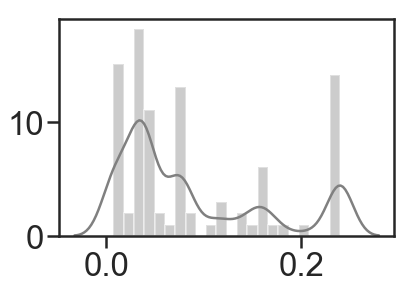

In [240]:
sns.distplot(df_omis[(df_omis.resp_sig == 'ns') & (df_omis.group == 'fx')].fit_pref.dropna().values)

In [205]:
# df_opto = df_vmmn[ (df_vmmn.paradigm.str.contains('chirp')) ]
# df_opto = df_opto.groupby('cluster_id').apply(get_opto_resp)

# high_ztc_units = df_opto[df_opto.ztc > 400].cluster_id.unique()
# df_opto = df_opto[~(df_opto.cluster_id.isin(high_ztc_units))]

df_vmmn.paradigm.unique()
df_omis = df_vmmn[df_vmmn.paradigm == 'sf_loc_omis']
tmp = df_tuning[df_tuning.fit_err < 0.9]
d_tmp = dict(zip(tmp.cluster_id, tmp.fit_pref.round(4)))
df_omis['fit_pref'] = df_omis.cluster_id.map(d_tmp)
df_omis['n_type'] = df_omis.cluster_id.map(neuron_type)

df_omis = df_omis.groupby('cluster_id').apply(get_resp_sig, stim1_name = 'dev2', 
                                              base =  (0.05, 0.35), stim = (0.35, 0.65))

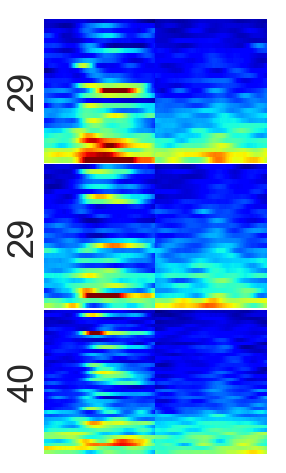

In [381]:
cond = 'layer'
data = df_omis
gr = data[ (data.resp_sig == 'exc') 
#             & (data.tun_group == 'out_odd') 
            & (data.group == 'fx')
#             & (data.n_type == 'fs')
            ]
# gr = gr[ (gr.fit_pref < 0.015) 
#             | (gr.fit_pref > 0.06) 
#             ]
# gr = gr[gr.fit_pref.isnull()]


# gr = gr.dropna()
gr = gr[(gr.times > 0.1) & (gr.times < 0.9)]
# gr = opto_df[(opto_df.group == 'wt') & (opto_df.r_groups == 1)]
n = int(gr[cond].unique().size)
# gr = gr[(gr.stim1.str.contains('0'))]

plt.figure(figsize = (4,8))
gs1 = mpl.gridspec.GridSpec(3, 1)
gs1.update(wspace=0.025, hspace=0.01) # set the spacing between axes. 

# f, ax = plt.subplots( n, sharex=True,figsize = (6,8))

# cbar_ax = f.add_axes([.91, .3, .03, .5])
sns.set_style("ticks")
for idx, val in enumerate(sorted(gr[cond].unique(), reverse=False)):
    ax = plt.subplot(gs1[idx])
    tmp = gr[gr[cond] == val]
#     tmp = df_psth[(df_psth.paradigm == 'opto_chirp')  & (df_psth.cluster_id.isin(tmp.cluster_id.unique()))]
    tmp = tmp.pivot('cluster_id', 'abs_times', 'Hz').dropna()
    tmp2 = tmp.values[ np.argsort(np.mean(tmp.values[:,120:150], axis = 1) )]
    g = sns.heatmap(tmp2, cmap = 'jet',  cbar = False,
                 ax = ax, xticklabels = False, yticklabels=False, vmax = 30,  vmin = 0, robust = True,
#                 cbar=idx == 0, cbar_ax=None if idx else cbar_ax,
                   )
    ax.set(xlabel = '', ylabel=tmp.index.size )
    
#     ax[i].set_title('Cluster group ' + str (i+1), loc = 'left') 
f.subplots_adjust(hspace=0.2) 
# ax[0].set_title(str(gr.stim1.unique()[0])  )
# plt.savefig('hm_omis_exc_fx.png')

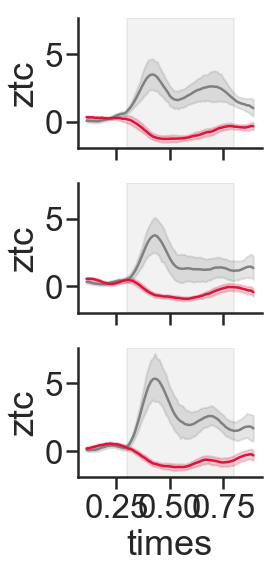

In [331]:
zsc = 'ztc'
cond = 'layer'
# gr = df_out
# gr = df_out
f, ax = plt.subplots(3, sharex=True, sharey=True, figsize = (4,8))
# ts_input = data
ts_input = gr[(gr.times > 0.1) & (gr.times < 0.9)]
# y_limits = [(-1, 30), (-1, 25), (-1, 25), (-1, 30), (-1, 25), (-1, 20) ]
for idx, val in enumerate(sorted(gr[cond].unique(), reverse=False)):
    tmp = ts_input[ts_input[cond] == val]
#     tmp = tmp[tmp.n_type == 'rs']
    tmp = tmp.sort_values(by = ['group'], ascending=False)
    sns.lineplot(data = tmp, x = 'times', y = zsc,  ci = 68, hue= 'stim1',
        estimator=np.nanmean, ax = ax[idx],  legend = False, palette = colors_stim[:2],
              )
#     ax[idx].set_ylim(-3, 13)
#     ax[idx].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[idx].axvspan(0.3, 0.8, alpha = 0.05, color='k')
# plt.axhline(y=0.002,xmin=0,xmax=3,c="black",linewidth=1,zorder=0, ls='dashed')

# plt.xlabel('Time (s)')
# plt.axvspan(0.4, 1.2,ymin = 0.95, ymax = 1, alpha=0.5, color='green')

plt.ylabel(zsc)
sns.despine()
plt.tight_layout()
# sns.despine(offset=5, trim=True);
# plt.savefig('line_omis_wt_inh.pdf')

In [319]:
np.where(np.array(omission.values()) == 2)[0].size/200

0.125

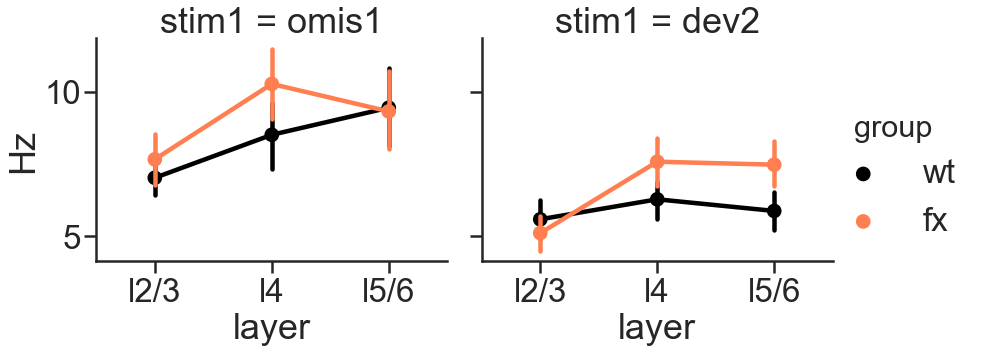

In [339]:
fig_inp = gr[(gr.times > 0.35) & (gr.times < 0.8) 
#              & (gr.layer == 'l5/6') 
            ]
# base = gr[(gr.times > 0) & (gr.times < 1)].groupby([ cond, 'group', 'stim1' ,'cluster_id']).mean().reset_index().Hz.values
# fig_inp = gr.groupby('cluster_id').apply(get_auc)

fig_inp = fig_inp.groupby([ cond, 'group'  ,'stim1', 'cluster_id']).mean().reset_index()

# fig_inp.loc[:,'bc_fr'] = fig_inp.Hz - base
# fig_inp = fig_inp[fig_inp.n_type != 'un']
fig_inp = fig_inp.sort_values(by = ['stim1', cond, 'group'], ascending = [False, True, False])
ax = sns.catplot( x = 'layer', y = "Hz", sharey = True,  data= fig_inp,  kind = 'point', ci = 68,  legend = True,
              palette = colors_group, sharex = False, hue = 'group', col = 'stim1', 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect = 1.2 ,
#                   col_wrap = 2, col = cond,
                )
# plt.savefig('point_omis_inh.pdf')

In [341]:
val = 'Hz'
cond = 'layer'
ls = []
# for lay in sorted(fig_inp['layer'].unique()):
#     ls = []
#     print lay
for l in sorted(fig_inp[cond].unique()):

    stat_inp = fig_inp[(fig_inp[cond] == l) 
                       & (fig_inp.stim1 == 'omis1')
                      ]
    x1 = stat_inp[(stat_inp.group == 'wt')][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx')][val].dropna().values


    print '\t', l, len(x1), len(x2)
    wt_mean, wt_sem = np.mean(x1), sstat.sem(x1)
    fx_mean, fx_sem = np.mean(x2), sstat.sem(x2)
    print wt_mean, wt_sem
    print fx_mean, fx_sem

    x1_x2 = sstat.ttest_ind(x1, x2)
    print x1_x2
#     ls.append(x1_x2[1])
    print '------------------------'
# pvals = np.array(ls)
# adj = multipletests(pvals, method='fdr_bh')

# print np.round(adj[1], 5)

	l2/3 36 19
7.010653903858003 0.6894917240424442
7.651006681575379 0.8777606661049125
Ttest_indResult(statistic=-0.5597886609187432, pvalue=0.5779819304231355)
------------------------
	l4 28 33
8.50174334272476 1.1885655383239198
10.265337337017002 1.1794591574539888
Ttest_indResult(statistic=-1.0467279603928428, pvalue=0.29949441421089973)
------------------------
	l5/6 29 40
9.440770890356118 1.4058313091787027
9.312199181072828 1.3316907040104067
Ttest_indResult(statistic=0.06526516960348516, pvalue=0.9481572215186548)
------------------------


In [ ]:
from statsmodels.stats.multitest import multipletests

In [ ]:
wt_std = fig_inp[(fig_inp.stim1 == 'std3') & (fig_inp.group == 'wt')].ztc.dropna().values
wt_dev = fig_inp[(fig_inp.stim1 == 'dev9') & (fig_inp.group == 'wt')].ztc.dropna().values
wt_ctr = fig_inp[(fig_inp.stim1 == 'ctr2') & (fig_inp.group == 'wt')].ztc.dropna().values

fx_std = fig_inp[(fig_inp.stim1 == 'std3') & (fig_inp.group == 'fx')].ztc.dropna().values
fx_dev = fig_inp[(fig_inp.stim1 == 'dev9') & (fig_inp.group == 'fx')].ztc.dropna().values
fx_ctr = fig_inp[(fig_inp.stim1 == 'ctr2') & (fig_inp.group == 'fx')].ztc.dropna().values

print "WT std/dev/ctr mean and sem" 
print np.mean(wt_std), sstat.sem(wt_std) 
print np.mean(wt_dev), sstat.sem(wt_dev) 
print np.mean(wt_ctr), sstat.sem(wt_ctr)

print "FX std/dev/ctr mean and sem"
print np.mean(fx_std), sstat.sem(fx_std) 
print np.mean(fx_dev), sstat.sem(fx_dev) 
print np.mean(fx_ctr), sstat.sem(fx_ctr)

print (len(wt_std), len(fx_std))

# print sstat.kruskal(x1, x2, x3)

p1 =  sstat.mannwhitneyu(wt_std, wt_dev)[1]
p2 = sstat.mannwhitneyu(wt_std, wt_ctr)[1]
p3 =  sstat.mannwhitneyu(wt_dev, wt_ctr)[1]

p4 =  sstat.mannwhitneyu(fx_std, fx_dev)[1]
p5 =  sstat.mannwhitneyu(fx_std, fx_ctr)[1]
p6 =  sstat.mannwhitneyu(fx_dev, fx_ctr)[1]

p7 =  sstat.mannwhitneyu(wt_std, fx_std)[1]
p8 =  sstat.mannwhitneyu(wt_dev, fx_dev)[1]
p9 =  sstat.mannwhitneyu(wt_ctr, fx_ctr)[1]

pvals = np.array((p1, p2, p3, p4, p5, p6, p7, p8, p9))
adj = multipletests(pvals, method='fdr_bh')
print pvals
print np.round(adj[1], 5)

In [ ]:
def get_auc(data, val = 'ztc'):
    tmp = data[(data.times < 1) & (data.times < 6)]
    auc = np.trapz(data[val])
    data.loc[:, 'auc'] = auc
    return data

In [ ]:
_inp = df_odd[(df_odd.resp_sig == 'exc')
              & (df_odd.tun_group == 'untun')
              & (df_odd.abs_times == 0.5)
              & (df_odd.layer == 'l5/6' )
              ]

f, ax = plt.subplots(3, 1, figsize = (3,9), sharey = True)
# _inp = _inp[~(_inp.cluster_id.isin(ctr2_units))]

val = ['ssa_hz', 'dd_hz', 'pe_hz' ]

for i in range(3):
    x = _inp[_inp.group == 'wt'].groupby('cluster_id')[val[i]].mean().dropna().values
    y = _inp[_inp.group == 'fx'].groupby('cluster_id')[val[i]].mean().dropna().values
    sns.distplot(x, 
                 kde_kws=dict(cumulative = True), 
    #              hist = False,
                 color = 'k', 
                 ax = ax[i])
    sns.distplot(y, kde_kws=dict(cumulative = True), 
    #              hist = False,
                 color = 'coral', 
                 ax = ax[i])
    # ax[0].axvline(x= 0, linestyle = '--')
    ax[i].set_xlim(-1, 1)
    sns.despine()

    print sstat.ks_2samp(x, y)
print len(x), len(y)
# plt.savefig('dist_l56_untun_odd.pdf')

In [ ]:
print len(x), len(y), len(x2), len(y2)
print sstat.ks_2samp(x, y)
print sstat.ks_2samp(x2, y2)

In [ ]:
val = 'Hz'
for l in sorted(fig_inp[cond].unique()):
    
    stat_inp = fig_inp[fig_inp[cond] == l]
    x1 = stat_inp[(stat_inp.group == 'wt') ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx') ][val].dropna().values
    
#     x3 = stat_inp[(stat_inp.group == 'wt') & (stat_inp.n_type == 'fs')][val].dropna().values
#     x4 = stat_inp[(stat_inp.group == 'fx') & (stat_inp.n_type == 'fs')][val].dropna().values
    
    print l
    print 'wt, rs', len(x1) , np.mean(x1), sstat.sem(x1)
    print 'fx, rs', len(x2) , np.mean(x2), sstat.sem(x2)
#     print 'wt, fs', len(x3) ,np.mean(x3), sstat.sem(x3)
#     print 'fx, fs', len(x4) ,np.mean(x4), sstat.sem(x4)

    print 'rs', sstat.mannwhitneyu(x1, x2)
#     print 'fs', sstat.mannwhitneyu(x3, x4)
    print '------------------------'


In [ ]:
ls_layer = []
val = 'Hz'
for l in sorted(fig_inp[cond].unique()):
    
    srat_inp = fig_inp[fig_inp[cond] == l]
    x1 = srat_inp[srat_inp.stim1 == 'std3'][val].dropna().values
    x2 = srat_inp[srat_inp.stim1 == 'dev9'][val].dropna().values
    x3 = srat_inp[srat_inp.stim1 == 'ctr2'][val].dropna().values
    
    print l
    std_mean, std_sem = np.mean(x1), sstat.sem(x1)
    dev_mean, dev_sem = np.mean(x2), sstat.sem(x2)
    ctr_mean, ctr_sem = np.mean(x3), sstat.sem(x3)

#     n = min(len(x1), len(x2), len(x3))

#     print sstat.kruskal(x1, x2, x3)

    std_dev = sstat.mannwhitneyu(x1, x2)
    std_ctr = sstat.mannwhitneyu(x1, x3)
    dev_ctr = sstat.mannwhitneyu(x2, x3)
    
    data_tmp = pd.DataFrame({cond: l, 'stim1': ['std', 'dev', 'ctr'], 
    'mean': [std_mean, dev_mean, ctr_mean ], 'sem': [std_sem, dev_sem, ctr_sem ], 
    'n_units': [len(x1), len(x2), len(x3)], 'group': 'wt', 'comparison': ['std_dev', 'std_ctr', 'dev_ctr'],
    'p_val': [std_dev[1], std_ctr[1], dev_ctr[1]], 'u_stat': [std_dev[0], std_ctr[0], dev_ctr[0]],
                         'test': 'MWU' })
    ls_layer.append(data_tmp)
    print '------------------------'
stat_table = pd.concat(ls_layer)
stat_table.head()

In [ ]:
cols = ['group', cond, 'comparison', 'test', 'u_stat', 'p_val', 'stim1', 'n_units', 'mean', 'sem' ]
stat_table[cols]

In [ ]:
df_odd[(df_odd.abs_times == 0.5) 
       & (df_odd.group == 'wt')].groupby([ 'resp_sig', 'n_type']).cluster_id.count()

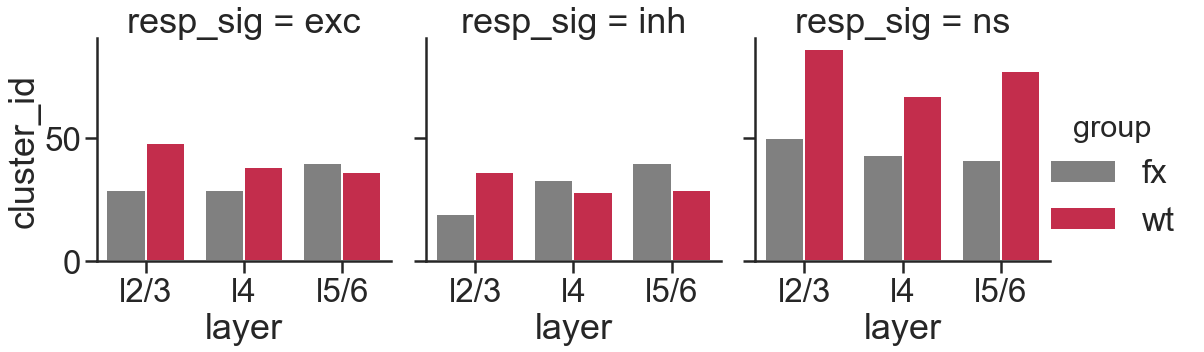

In [361]:
tmp = df_omis[df_omis.abs_times == 0.5].groupby(['group', 'layer' , 'resp_sig']).cluster_id.count().reset_index()
sns.catplot(data = tmp, x = 'layer', y = 'cluster_id', hue = 'group', col = 'resp_sig',kind = 'bar')

In [ ]:
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.pie(students, labels = langs,autopct='%1.2f%%')
plt.show()

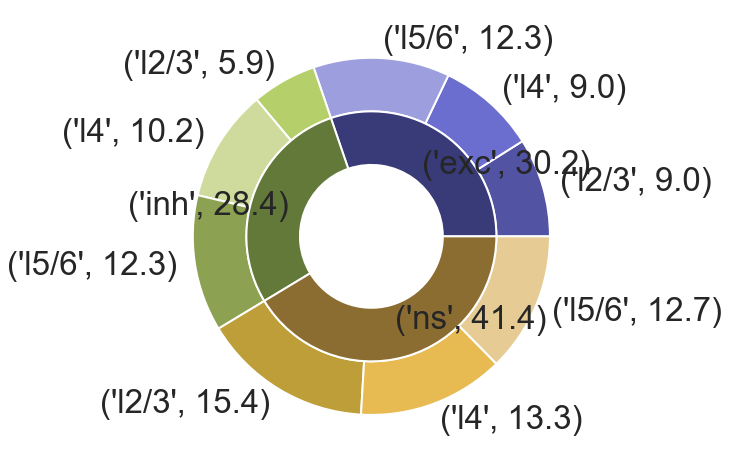

In [356]:
# plot nested pie charts
tmp = df_omis[(df_omis.abs_times == 0.5) & (df_omis.group == 'fx') ]
tmp2 = tmp.groupby([ 'resp_sig', 'layer']).cluster_id.count().reset_index().sort_values(by = ['resp_sig'])
total = tmp2.cluster_id.values.sum()

fig, ax = plt.subplots(figsize = (8, 8))
ax.axis('equal')
width = 0.3

cm = plt.get_cmap("tab20b")
labels = tmp2['layer'].values
values = tmp2.cluster_id.values
cin = cm(np.array([1,2,3, 6,7,5, 9, 10, 11]))

wedges, texts = ax.pie(values, radius=1,  colors = cin, labels = zip(labels, np.round(values/total*100, 1)),
                      wedgeprops=dict(width=width, edgecolor='w'))


cout = cm(np.arange(3)*4)
labels = tmp2.groupby('resp_sig').sum().index.values
values = tmp2.groupby('resp_sig').sum().cluster_id.values
wedges, texts = ax.pie(values, radius = 1-width,  labels = zip(labels, np.round(values/total*100, 1)),
                       wedgeprops=dict(width=width, edgecolor='w'),
                                      labeldistance=0.7, colors = cout)

# plt.savefig('pie_fx_omis.pdf')

In [ ]:
texts

In [ ]:
f, ax = plt.subplots(3, 2, sharex=True,sharey=True, figsize = (6,12))
bins = np.arange(0, 1001, 100)
wt_total = gr[(gr.abs_times == 0.5) & (gr.group == 'wt')].depth.values
a_wt = np.histogram(wt_total, bins= bins)

fx_total = gr[(gr.abs_times == 0.5) & (gr.group == 'wt')].depth.values
a_fx = np.histogram(fx_total, bins= bins)
axs = ax.ravel()
for idx, val in enumerate(sorted(gr[cond].unique())):
    tmp_wt = gr[ (gr.abs_times == 0.5) & (gr[cond] == val) & (gr.group == 'wt')].depth.values
    tmp_fx = gr[ (gr.abs_times == 0.5) & (gr[cond] == val) & (gr.group == 'fx')].depth.values
    
    b_wt = np.histogram(tmp_wt, bins= bins)
    b_fx = np.histogram(tmp_fx, bins= bins)
#     print tmp_depth.size
    axs[idx].plot( b_wt[0]/a_wt[0], bins[1:],   color = 'k')
    axs[idx].plot( b_fx[0]/a_fx[0], bins[1:],  color = 'coral')
    axs[idx].set_title(val)
#     print _depth.size
sns.despine()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xlim(-200, 1200)
# plt.savefig('dist_depth-bysf.pdf')

## SSA and DD indices

In [ ]:
good_units.size

In [ ]:
df_vmmn_opto = pd.concat([tmp0, tmp1])

In [ ]:
_inp = df_odd[(df_odd.resp_sig == 'exc')
              & (df_odd.abs_times == 0.5)
#               & (df_odd.group == 'fx')
              ]
# _inp = _inp[~(_inp.cluster_id.isin(ctr2_units))]
_inp = _inp.sort_values(by = 'group', ascending=False)
g = sns.scatterplot(data = _inp, x = 'ssa_hz', y= 'dd_hz',  
                    style = 'group',  hue = 'group', sizes = (20, 200)
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_axis_labels('ssa', 'dd')
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.axvline(x= 0, linestyle = '--')
plt.axhline(y= 0, linestyle = '--')

In [ ]:
_inp[_inp.group == 'wt'].groupby('cluster_id')[val].mean().dropna().values

In [ ]:
_inp[_inp.group == 'wt'].groupby('cluster_id')[val].mean().dropna().values

In [ ]:
# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w')

# tmp_odd = df_odd[(df_odd.times > 0.35) & (df_odd.times < 0.8)].groupby([ 'group', 'layer', 'n_type' ,'resp_sig', 
#                             'cluster_id', 'stim1']).mean().reset_index().dropna()
# base = df_odd[(df_odd.times > 0) & (df_odd.times < 0.3)].groupby([ 'group', 'layer', 'n_type' ,'resp_sig', 
#                             'cluster_id', 'stim1']).mean().reset_index().dropna().Hz.values
# tmp_odd.loc[:,'bc_fr'] = tmp_odd['Hz'] - base

# fig_inp = tmp_odd[(tmp_odd.resp_sig == 'exc') 
# #                  & (tmp_odd.group == 'fx')
# #                  & (tmp_odd.n_type == 'fs')
#                    &(tmp_odd.stim1 == 'ctr2')
#                  ]
fig_inp = df_odd[
    (df_odd.resp_sig == 'exc') 
#        & (tmp_odd.group == 'wt')
        &(df_odd.abs_times == 0.5)
    & (df_odd.n_type == 'fs')
                  ]

fig_inp = fig_inp.sort_values(by = ['layer' ,'group'], ascending= [ True, False])
ax = sns.catplot(x = "layer", y = "pe_hz",   data= fig_inp,  kind = 'point', ci = 68, 
                  palette = colors_group, hue = 'group', 
#                  col = 'layer', col_wrap = 1,
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
plt.savefig('point_fs_mm_layer.pdf')

In [ ]:
val = 'ssa_hz'
cond = 'layer'
wt_in = fig_inp[(fig_inp[cond] == 'l2/3') & (fig_inp.group == 'wt')][val].dropna().values
wt_out = fig_inp[(fig_inp[cond] == 'l4') & (fig_inp.group == 'wt')][val].dropna().values
wt_untun = fig_inp[(fig_inp[cond] == 'l5/6') & (fig_inp.group == 'wt')][val].dropna().values

fx_in_odd = fig_inp[(fig_inp[cond] == 'l2/3') & (fig_inp.group == 'fx')][val].dropna().values
fx_out_odd = fig_inp[(fig_inp[cond] == 'l4') & (fig_inp.group == 'fx')][val].dropna().values
fx_untun = fig_inp[(fig_inp[cond] == 'l5/6') & (fig_inp.group == 'fx')][val].dropna().values

print "WT L2/3 4 5/6 mean and sem" 
print np.mean(wt_in), sstat.sem(wt_in) 
print np.mean(wt_out), sstat.sem(wt_out) 
print np.mean(wt_untun), sstat.sem(wt_untun)

print "FX L2/3 4 5/6 mean and sem"
print np.mean(fx_in_odd), sstat.sem(fx_in_odd) 
print np.mean(fx_out_odd), sstat.sem(fx_out_odd) 
print np.mean(fx_untun), sstat.sem(fx_untun)

print (len(wt_in), len(wt_out), len(wt_untun), len(fx_in_odd), len(fx_out_odd), len(fx_untun))

# print sstat.kruskal(x1, x2, x3)

p1 =  sstat.mannwhitneyu(wt_in, wt_out)[1]
p2 = sstat.mannwhitneyu(wt_in, wt_untun)[1]
p3 =  sstat.mannwhitneyu(wt_out, wt_untun)[1]

p4 =  sstat.mannwhitneyu(fx_in_odd, fx_out_odd)[1]
p5 =  sstat.mannwhitneyu(fx_in_odd, fx_untun)[1]
p6 =  sstat.mannwhitneyu(fx_out_odd, fx_untun)[1]

p7 =  sstat.mannwhitneyu(wt_in, fx_in_odd)[1]
p8 =  sstat.mannwhitneyu(wt_out, fx_out_odd)[1]
p9 =  sstat.mannwhitneyu(wt_untun, fx_untun)[1]

pvals = np.array((p1, p2, p3, p4, p5, p6, p7, p8, p9))
adj = multipletests(pvals, method='fdr_bh')
print pvals
print np.round(adj[1], 5)

In [ ]:
ls_layer = []
val = 'ssa_hz'
for l in sorted(fig_inp['tun_group'].unique()):
    
    stat_inp = fig_inp[fig_inp['tun_group'] == l]
    x1 = stat_inp[stat_inp.group == 'wt'][val].dropna().values
    x2 = stat_inp[stat_inp.group == 'fx'][val].dropna().values
 
    print len(x1), len(x2)
#     x1_mean, x1_sem = np.mean(x1), sstat.sem(x1)
#     x2_mean, x2_sem = np.mean(x2), sstat.sem(x2)

    x1_x2 = sstat.mannwhitneyu(x1, x2)
    ls_layer.append(x1_x2[1])
#     data_tmp = pd.DataFrame({ 'group': ['wt', 'fx'], 
#     'mean': [x1_mean, x2_mean ], 'sem': [x1_sem, x2_sem ], 'pref':l,
#     'n_units': [len(x1), len(x2)], 'tuning': 'pe',
#     'p_val': x1_x2[1], 'stat': x1_x2[0]  })
#     ls_layer.append(data_tmp)
    print '------------------------'
pvals = np.array(ls_layer)
adj = multipletests(pvals, method='fdr_bh')
print pvals
print adj[1]
# stat_table = pd.concat(ls_layer)
# stat_table.head()



In [ ]:
stat_table

In [ ]:
tmp = df_odd[df_odd.abs_times == 0.5].groupby(['group', 'et', 'pref']).agg({'Hz': 'count'}).groupby(level=1).apply(lambda x:
                                                  x / float(x.sum())).reset_index()
tmp = tmp.sort_values(by = ['pref', 'group'], ascending= [False, False])

ax = sns.catplot(x = "pref", y = "Hz",   data = tmp,  kind = 'bar', ci = 68, 
                  palette = colors_group, hue = 'group', 
#                  col = 'n_type', col_wrap = 1,
                    size = 5, aspect=1.5
                    )
# plt.savefig('bar-pref-dist-proportion-by-et.pdf')

In [ ]:
tmp.groupby(['group', 'pref']).count()

In [ ]:
val = 'Hz'
cond = 'pref'
fig_inp = tmp
for l in sorted(fig_inp[cond].unique()):
    
    stat_inp = fig_inp[fig_inp[cond] == l]
    x1 = stat_inp[(stat_inp.group == 'wt') ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx') ][val].dropna().values
    
#     x3 = stat_inp[(stat_inp.group == 'wt') & (stat_inp.n_type == 'fs')][val].dropna().values
#     x4 = stat_inp[(stat_inp.group == 'fx') & (stat_inp.n_type == 'fs')][val].dropna().values
    
    print l
    print 'wt', len(x1) , np.mean(x1), sstat.sem(x1)
    print 'fx', len(x2) , np.mean(x2), sstat.sem(x2)
#     print 'wt, fs', len(x3) ,np.mean(x3), sstat.sem(x3)
#     print 'fx, fs', len(x4) ,np.mean(x4), sstat.sem(x4)

    print sstat.mannwhitneyu(x1, x2)
#     print 'fs', sstat.mannwhitneyu(x3, x4)
    print '------------------------'


In [ ]:
tmp_tun

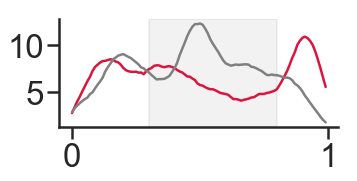

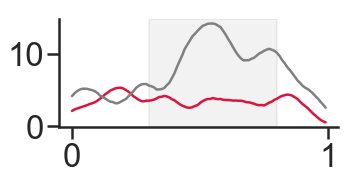

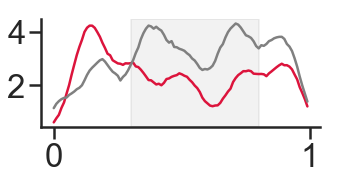

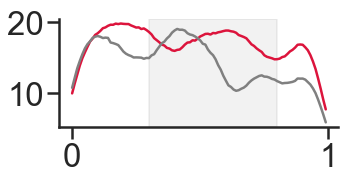

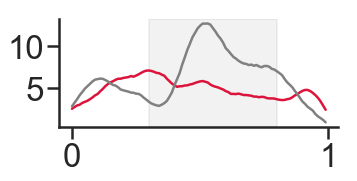

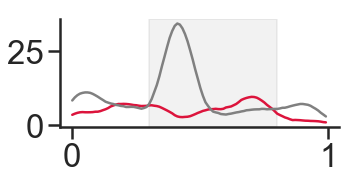

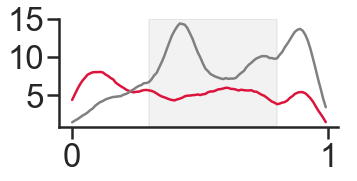

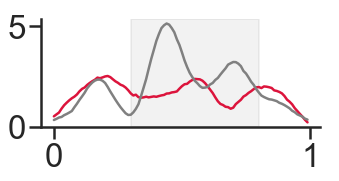

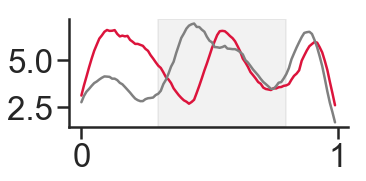

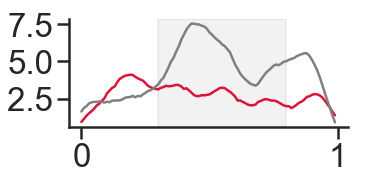

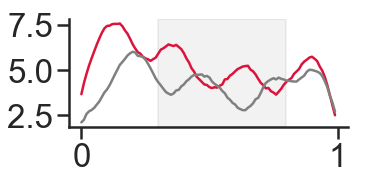

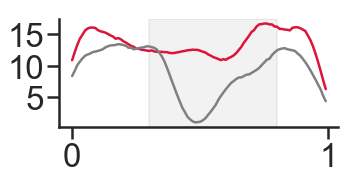

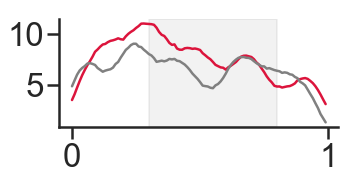

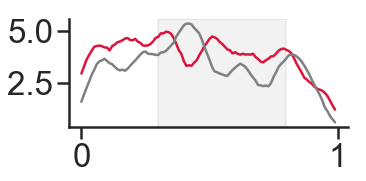

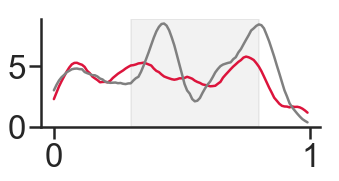

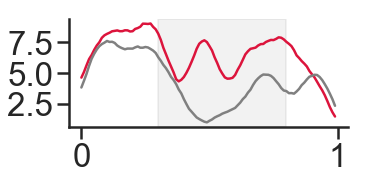

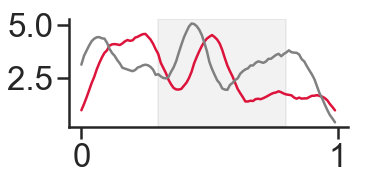

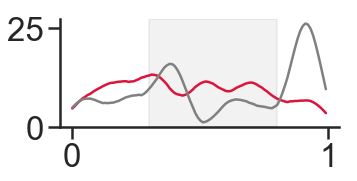

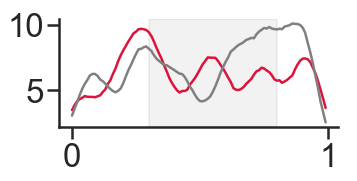

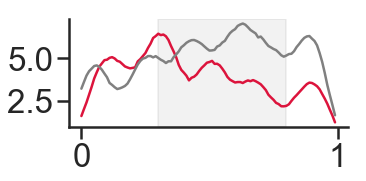

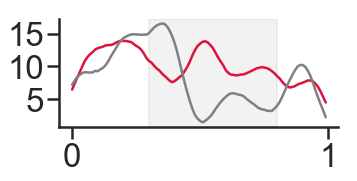

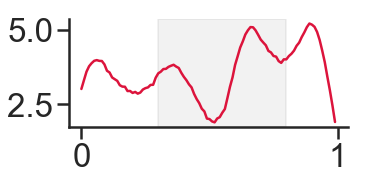

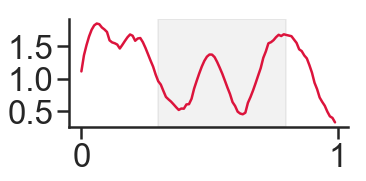

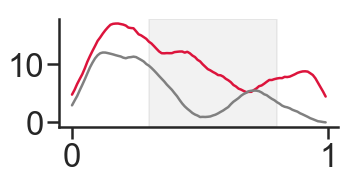

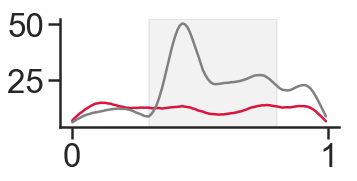

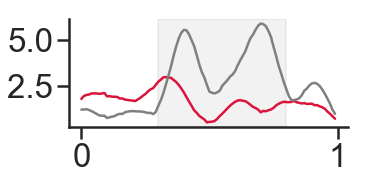

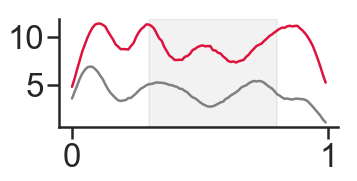

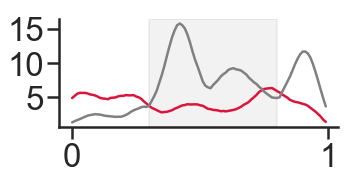

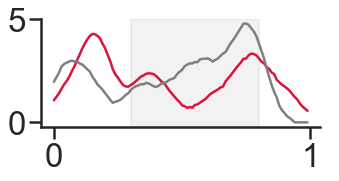

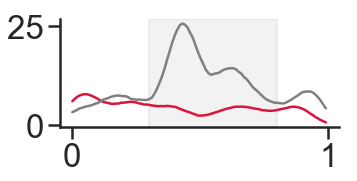

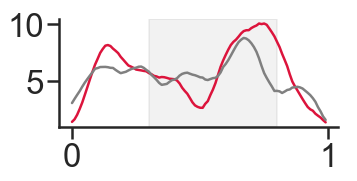

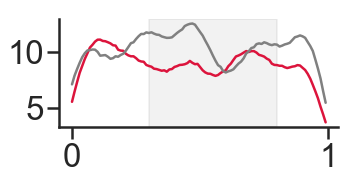

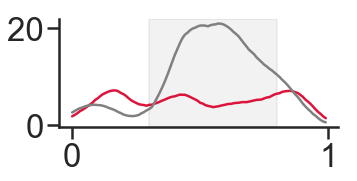

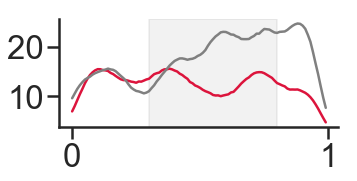

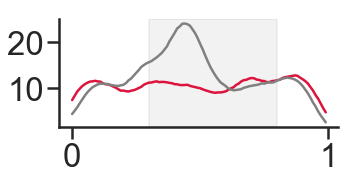

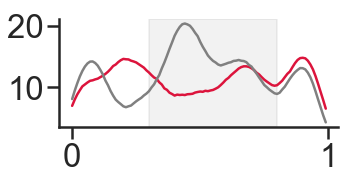

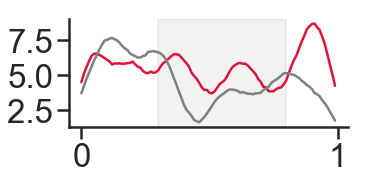

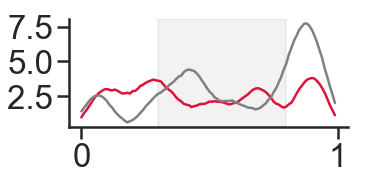

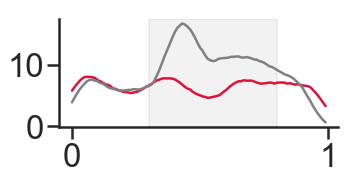

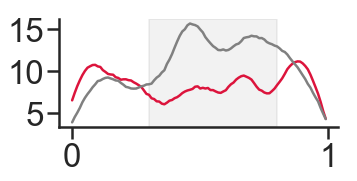

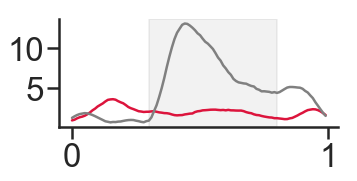

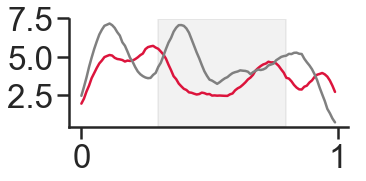

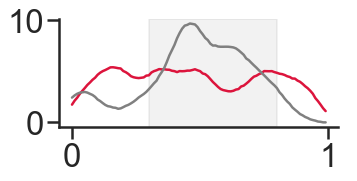

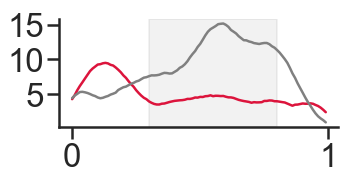

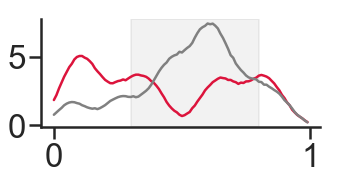

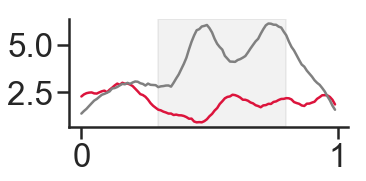

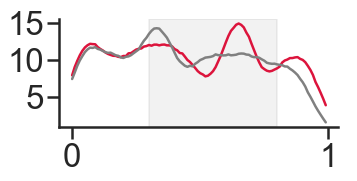

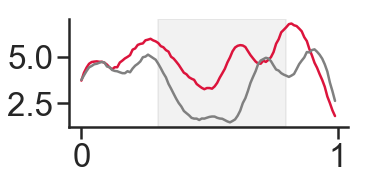

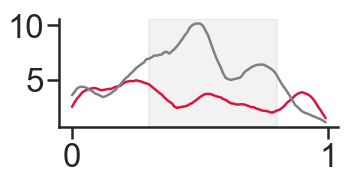

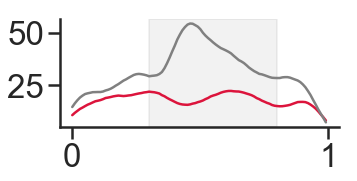

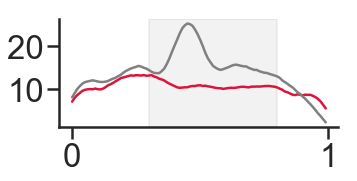

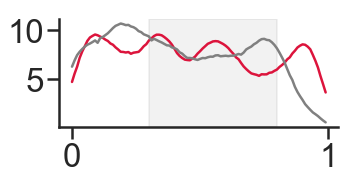

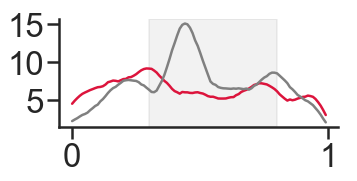

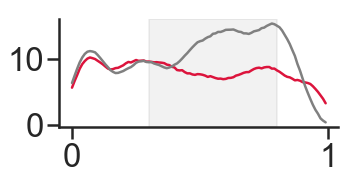

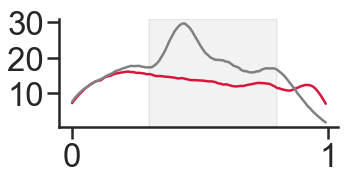

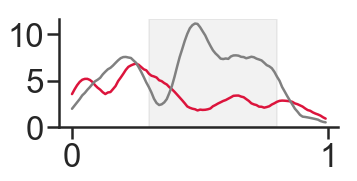

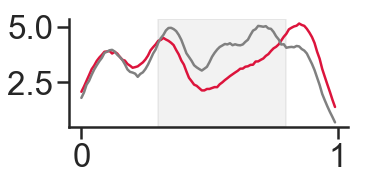

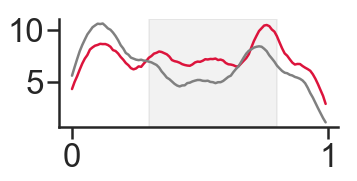

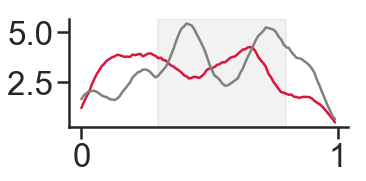

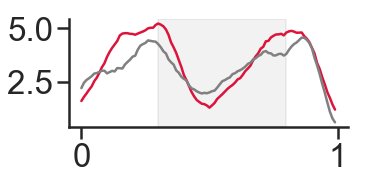

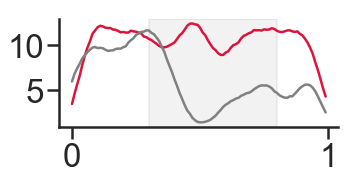

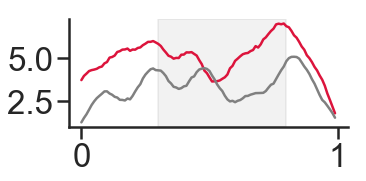

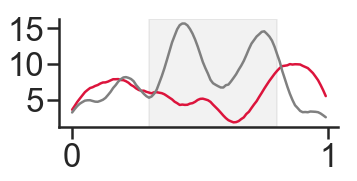

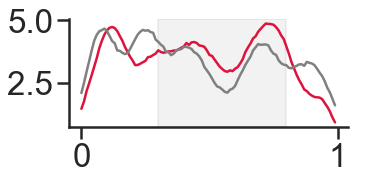

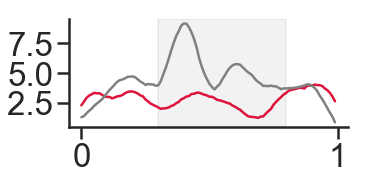

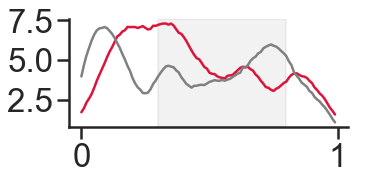

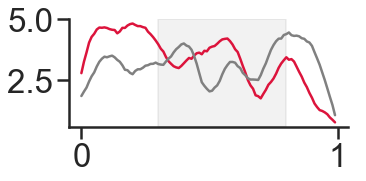

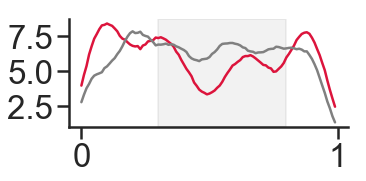

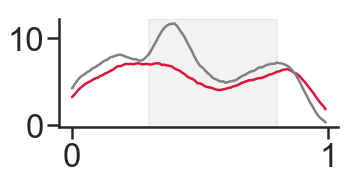

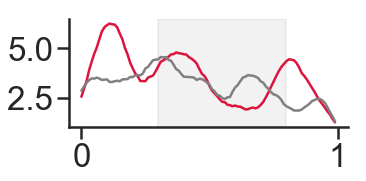

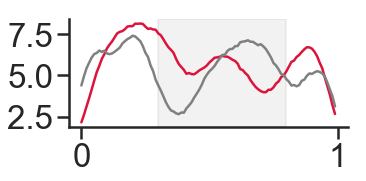

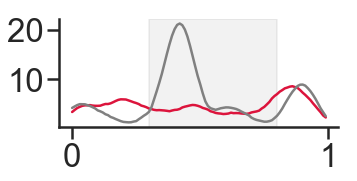

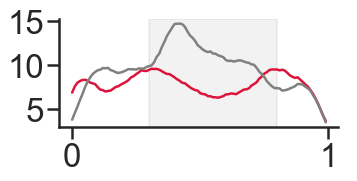

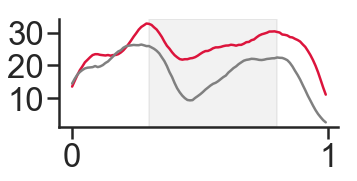

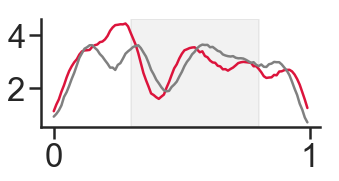

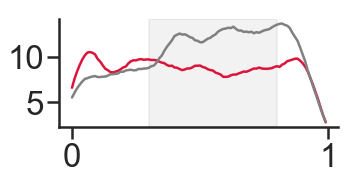

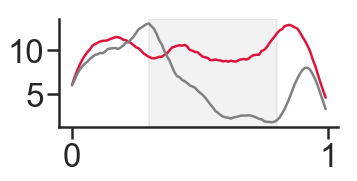

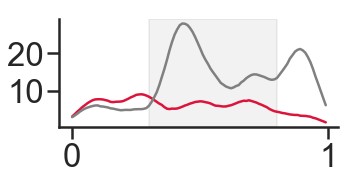

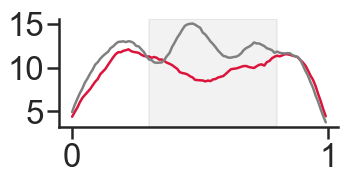

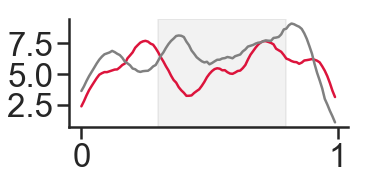

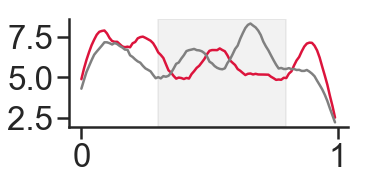

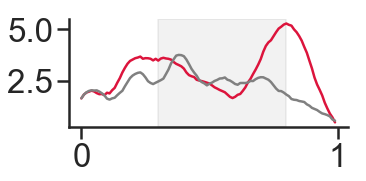

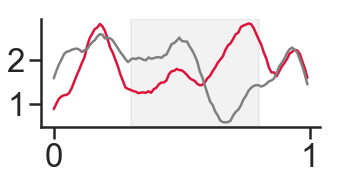

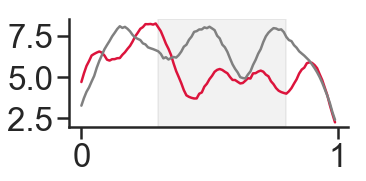

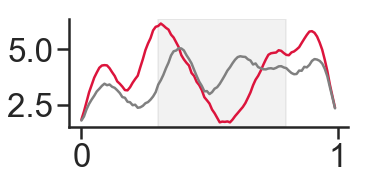

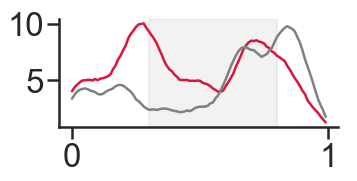

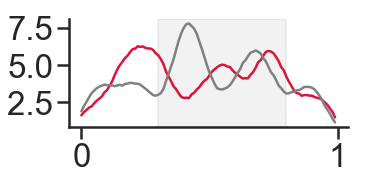

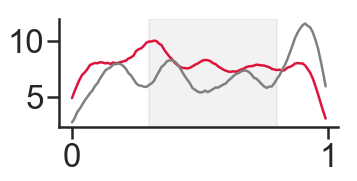

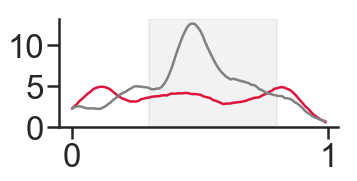

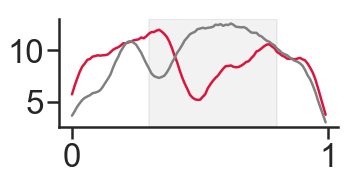

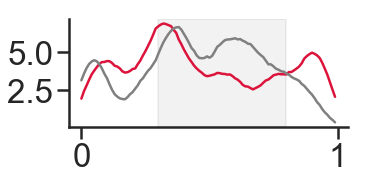

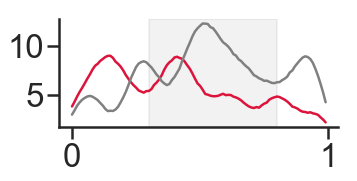

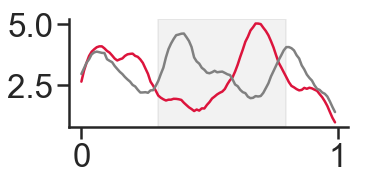

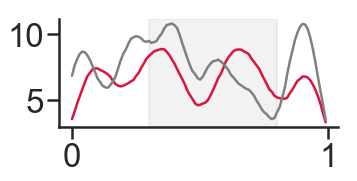

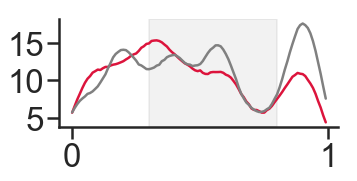

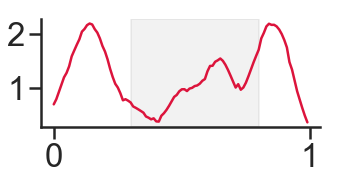

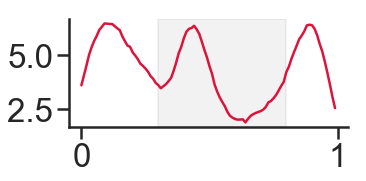

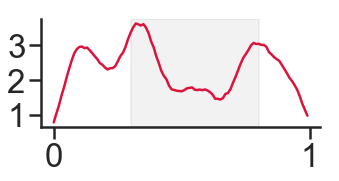

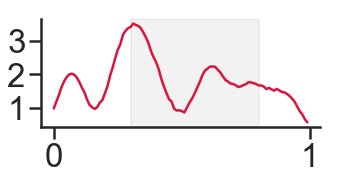

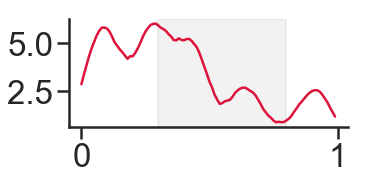

In [384]:
stims = sorted(df_odd.stim1.unique())
colors = ['crimson', 'gray', 'gray']
_inp = df_omis[(df_omis.group == 'wt') 
#               & (df_omis.n_type == 'fs')  
              & (df_omis.resp_sig == 'inh')]

for unit in _inp.cluster_id.unique()[:]:
    tmp = df_omis[df_omis.cluster_id == unit]
    tmp = tmp.sort_values(by = ['times', 'stim1'], ascending = [True, False])
    f, ax = plt.subplots(1 , figsize = (5,2), sharey=False, sharex=False, facecolor = 'w')
    
#     tmp_tun = df_tuning[df_tuning.cluster_id == unit]
#     ax[0].plot(tmp_tun.stim1, tmp_tun.bc_fr, c = 'gray')
    
    sns.despine()
#     plt.suptitle(str(round(tmp.ssa_hz.values[0],2)) + ' '
#                  +  str(round(tmp.dd_hz.values[0],2)), size = 14 )
    for idx, stim in enumerate(sorted(tmp.stim1.unique())):
        ax.plot( tmp[(tmp.stim1 == stim)].times, tmp[(tmp.stim1 == stim)].Hz, label = stims[idx], color = colors[idx]  )
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     break
    ax.axvspan(0.3, 0.8, alpha = 0.05, color='k')
# plt.savefig(str(unit) + 'fx_omis_example.pdf')

## Waveform-based RS/FS splitting

In [ ]:
import resampy
import scipy.optimize as opt
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [ ]:
result = df_tmt
samples = np.concatenate([np.arange(82)] * result.cluster_id.unique().size)
result['samples'] = samples
spk_width = {}
d_fwhm = {}
tr2peak = {}
neuron_type = {}
ls = []
ls2 = []
ls3 = []
# f, ax = plt.subplots(1,2)
for ii in result.cluster_id.unique()[:]:
#trough-to-peak    
    #tp =  result[(result['cuid'] == ii)  & (result.index > 18)  ].tmt.idxmax() - result[(result['cuid'] == ii)  & (result.index == 18)  ].index
    tmt_data = np.array(result[(result['cluster_id'] == ii)   ].tmt)

    y = resampy.resample( tmt_data[::-1] , 1 ,10,  filter='sinc_window',
                                    num_zeros=10, precision=5,
                                    window=ssig.hann)
    trough_idx = y.argmin()
    peak_idx = y[:y.argmin()].argmax()
#     plt.plot(y)
#     plt.axvline(x= trough_idx, color = 'k', linestyle = '--')
#     plt.axvline(x= peak_idx, color = 'r',linestyle = '--')
#     plt.axvline(x= peak_idx-100, color = 'b',linestyle = '--')
#     plt.show()

    tp = abs((trough_idx - peak_idx)/300.0)
    
    x = np.arange(y.size)
    y_gaus = y*(-1)
    popt,pcov = opt.curve_fit(gaus,x,y_gaus,p0=[0.2, y.argmin(), 10])
    fwhm = popt[-1]/300*2.355
    
#     plt.plot(x,y*(-1),'b+:')
#     plt.plot(x,gaus(x,*popt),'r--')
#     plt.show()

    f,pxx = ssig.welch(tmt_data, fs=3e4,  nfft=5096,  nperseg=48,
                          return_onesided=True, scaling='spectrum')

    df = np.vstack((f, pxx))
    df = pd.DataFrame(df)
    idx = df.T[1].idxmax()
    w = df.T[0][idx]
    w = 1/w*1000.0

    ls2.append(w)
    ls.append(tp)
    
    spk_width[ii] = w
    tr2peak[ii] = tp
    
    if tp < 0.45 and w < 1.2:
        neuron_type[ii] = 'fs'
    elif tp > 0.45 and w > 1.2:
        neuron_type[ii] = 'rs'
    else:
        neuron_type[ii] = 'un'

#p/t ratio
    edge = 100
    if peak_idx < 100:
        edge = peak_idx
    y_slope = y[peak_idx-edge:peak_idx]
    x_slope = np.arange(y_slope.size)
    slope, intercept, r_value, p_value, std_err = sstat.linregress(x_slope, y_slope)
    ls3.append(1e3*(slope))
    
#     plt.plot(x_slope, y_slope, 'o')
#     plt.plot(x_slope, intercept + slope*x_slope, 'r')
#     plt.show()
result['n_type'] = result.cluster_id.map(neuron_type)
result['sp_w'] = result.cluster_id.map(spk_width)
result['fwhm'] = result.cluster_id.map(d_fwhm)
result['tp'] = result.cluster_id.map(tr2peak)

In [ ]:
total = result.cluster_id.unique().size
print total
print result[result['samples'] == 0].groupby('n_type').cluster_id.count()/total


In [ ]:
d_group = dict(zip(df_vmmn['cluster_id'], df_vmmn.group))
result['group'] = result.cluster_id.map(d_group)

In [ ]:
result.head()

In [ ]:
sns.lineplot(x = 'samples', y = 'tmt', data = result[(result.group == 'fx') 
             & (result.n_type.str.contains('s'))], hue = 'n_type', 
             ci = 95, legend = False, palette = ['blue', 'magenta'])
sns.despine()
plt.xlim(20,)
# plt.savefig('fx_template_wvform_odd.pdf')

In [ ]:
g = (sns.jointplot(x = 'sp_w', y = 'tp', data= result[(result.samples == 0) 
                & (result.group == 'wt')], stat_func= None,
             color= "k", s = 10)
       .plot_joint(sns.kdeplot, zorder=0, n_levels=6))
g.set_axis_labels('', '')
plt.xlim(0.3, 1.8)
plt.ylim(0, 1.5)
plt.axvline(x= 1.2, linestyle = '--')
plt.axhline(y= 0.45, linestyle = '--')
# plt.savefig('wt_ntype_split_odd.png')

In [ ]:
result[result.samples == 0].groupby(['group', 'n_type']).mean()

In [ ]:
y_sf = resampy.resample( X.T , 1 ,5,  filter='sinc_window',
                                num_zeros=10, precision=5,
                                window=ssig.hann)

## Linear Discriminant Analysis

In [ ]:
plt.plot(y_sf[0])

In [ ]:

plt.plot(X[:,0])

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [ ]:
x_tmp = tmp_3km[(tmp_3km.r_groups != 6) & (tmp_3km.stim1 != 'std3') & (tmp_3km.group == 'fx')]
x_tmp = x_tmp[~(x_tmp.cluster_id.isin(ctr2_units))]
x_tmp = x_tmp[(x_tmp.times > 0.2) & (x_tmp.times<0.9)]
X = x_tmp.pivot('cuid', 'times', 'zscore').values
y = x_tmp.pivot('cuid', 'times', 'stim1').values[:,0]
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, y).transform(X)
# pca = PCA(n_components=2)
# X_r = pca.fit(X).transform(X)

In [ ]:
for color, i, target_name in zip(colors, ['ctr2', 'dev9', 'std3'], y):
    plt.scatter(X_r[y == i], X_r[y == i], alpha=.8, color=color, s = 20,
                label=y)
# plt.ylim(-6, 6)
# plt.xlim(-6, 6)

In [ ]:
sns.distplot(X_r[y == 'ctr2'])
sns.distplot(X_r[y == 'dev9'])


In [ ]:
lda_df = pd.DataFrame(X_r, columns= ['comp1', 'comp2'])
lda_df['stim1'] = y
v = lda_df.groupby('stim1').mean()
print v
v = v.values
origin = [0], [0] # origin point
plt.quiver( [0, 0, 0], [0, 0, 0], v[:,0], v[:,1], angles='xy', scale_units='xy', scale=1, color = colors, width = 0.015)
plt.ylim(-1, 1)
plt.xlim(-1, 1)

In [ ]:
df2.head()

## Units trial-based analysis

In [ ]:
# target_units = df_odd[(df_odd.resp_sig == 'exc')
#               & (df_odd.pref != 2)
#                & (df_odd.pref >-1)
#               ].cluster_id.unique()
# _data = df_spikes[df_spikes.cluster_id.isin(target_units)]
_data = df_spikes
df2 = _data[(_data.loc[:, 'times'] <= 120)] #sf-tuning
df2.loc[:, 'trial_n'] = df2.loc[:, 'times'] //1.0
df2.loc[:,'stim1'] = df2.loc[:, 'trial_n'].map(sf_tuning)
df2.loc[:, 'trial_spikes'] = df2.times - df2.trial_n
df2 = df2[(df2.trial_spikes > 0.35) & (df2.trial_spikes < 0.8)]

df3 = _data[(_data.loc[:, 'times'] > 120)   & ( _data.loc[:, 'times']<=320)] #sf-nov-odd
df3.times = df3.times - 120
df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
df3.loc[:,'stim1'] = df3.loc[:, 'trial_n'].map(oddball)
df3.loc[:,'trial_spikes'] = df3.times - df3.trial_n
df3 = df3[(df3.trial_spikes > 0.35) & (df3.trial_spikes < 0.8)]

## SF decoding

In [ ]:
l5_units = df_odd[df_odd.layer == 'l5/6'].cluster_id.unique()
df2 = df2[df2.cluster_id.isin(l5_units)]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from collections import defaultdict
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
df2['group'] = df2.et.map(groups)
# df2_sub = df2[(df2.trial_spikes >= 0.65) & (df2.trial_spikes < 0.75) & (df2.group == 'fx')]
# resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
# resp_units = resp_units[resp_units.times > 10].cluster_id.unique()

In [ ]:
tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 'trial_n']).trial_spikes.count().reset_index()
tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
tmp2 = tmp2.fillna(0)


In [ ]:
df2_l2.head()

In [ ]:
ls_cond = []
ls_conf_matrix = []
nested_dict = lambda: defaultdict(nested_dict)
d_coef = nested_dict()
sh_flag = False
y_ = np.array(sf_tuning.values())
time_w = [(0, 1), (0.35, 0.45), (0.45, 0.55), (0.55, 0.65), (0.65, 0.75)]

for gr in df2.group.unique()[1:]:
    print gr
    for w in time_w[4:]:
        print w
        df2_sub = df2[(df2.trial_spikes >= w[0]) & (df2.trial_spikes < w[1]) & (df2.group == gr)]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
        tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
        tmp2 = tmp2.fillna(0)

        ls = []
# coef_arr = np.zeros((100,5, _data.cuid.unique().size ))


        x_ = tmp2.values
        for i in range(10):
#             if sh_flag == True:
#                 x_sh = np.zeros((100,_data.cuid.unique().size ))
#                 y = np.array([0, 1, 2, 3 ,4]*20)
#                 for u in (np.unique(y)):
#                     x_sh[(u*20):(u*20+20)] = permute_columns(x[y==u])
#                 y_sh = sorted(y)
#                 x_, y_ = x_sh, y_sh
            X_train, X_test, y_train, y_test = train_test_split(x_, y_,
                                                                #random_state=42,
                                                                stratify = y_,
                                                                test_size = 0.5)
#             train_samples, n_features = X_train.shape
#             n_classes = np.unique(y).shape[0]
            #print np.unique(y_test, return_counts = True)
#             models = { 'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}
#             solver = 'lbfgs'
#             # Add initial chance-level values for plotting purpose
#             accuracies = [1 / n_classes]
#             times = [0]
#             densities = [1]
#             model = 'multinomial'
#             model_params = models[model]

#             # Small number of epochs for fast runtime

#             lr = LogisticRegression(solver=solver,
#                                     multi_class='multinomial',
#                                     C = 1,
#                                     penalty='l2',
#                                     fit_intercept=True,
#                                     #max_iter=100,
#                                     #random_state=42,
#                                     )

#             lr.fit(X_train, y_train)
            lda.fit(X_train, y_train)
            y_pred = lda.predict(X_test)
            acc = cross_val_score(lda, x_, y_, cv = kf)
            conf_m = metrics.confusion_matrix(y_test, y_pred)
            ls_conf_matrix.append(conf_m)
            accuracy = np.sum(y_pred == y_test) / len(y_test)
            tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': accuracy}, index = [0])
            ls_cond.append(tmp_df)
        #     density = np.mean(lr.coef_ != 0, axis=1) * 100
        #     coef_arr[i] = lr.coef_
#             ls.append(accuracy)
            


In [ ]:
f, ax = plt.subplots(figsize = (8, 6))
cm = np.sum(ls_conf_matrix, axis = 0)
sns.heatmap(cm, annot=True, cmap = 'Blues', ax = ax, annot_kws={"fontsize":14})
ax.set_xlabel('Predicted SF')
ax.set_ylabel('True SF')

In [ ]:
out = pd.concat(ls_cond)
out.loc[:,'error'] = 1 - out.acc
out.head()

In [ ]:
sns.catplot(x = 'window', y = 'error', data = out, hue = 'group', 
            kind = 'point', height = 5, aspect = 1.5, palette = colors_group , ci = 68)
plt.ylim(0, 0.3)
# plt.savefig('point-sf-decod-lda-bytime.pdf')

In [ ]:
out[out.window > 0.5].groupby(['group', 'window']).error.mean()

In [ ]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
kf = KFold(n_splits = 4)
ls_cond = []
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
     random_state = 3)
time_w = [(0, 1), (0.35, 0.45), (0.45, 0.55), (0.55, 0.65), (0.65, 0.75)]
_data = df2
for gr in _data.group.unique():
    for w in time_w:
        df2_sub = _data[(_data.trial_spikes >= w[0]) & (_data.trial_spikes < w[1]) & (_data.group == gr)]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
        tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
        tmp2 = tmp2.fillna(0)

        ls = []
# coef_arr = np.zeros((100,5, _data.cuid.unique().size ))

        x_ = tmp2.values
        y_ = sf_tuning.values()
        
        print gr, w, x_.shape

        scores = cross_val_score(lda, x_, y_, cv = rskf)
#         print scores
        tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': scores})
        ls_cond.append(tmp_df)

### by rec decoding

In [ ]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
kf = KFold(n_splits = 4)
ls_cond = []
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
     random_state = 3)
for fname in df2.path.unique():
    for w in time_w:
        df2_sub = df2[(df2.trial_spikes >= w[0]) & (df2.trial_spikes < w[1]) & (df2.path == fname)]
        gr = df2_sub.group.unique()[0]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
    
        n_units = tmp.cluster_id.unique().size
        x = np.zeros((120, n_units))
        for idu, unit in enumerate(sorted(tmp.cluster_id.unique())):
            tmp2 = tmp[tmp.cluster_id == unit]
            trials = tmp2.trial_n.values.astype(int)
            sp_counts = tmp2.trial_spikes.values
            x[trials, idu] = sp_counts
        
        ls = []
# coef_arr = np.zeros((100,5, _data.cuid.unique().size ))

        x_ = x
        y_ = sf_tuning.values()

        scores = cross_val_score(lda, x_, y_, cv = kf)
#         print scores
        tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': scores, 'fname':fname} )
        ls_cond.append(tmp_df)

In [ ]:
out = pd.concat(ls_cond)
out.loc[:,'error'] = 1 - out.acc
out.head()

In [ ]:
out.groupby(['group', 'window']).error.agg(['mean', 'std'])

### Unit based slope across trials

In [ ]:
from sklearn.linear_model import TheilSenRegressor

In [ ]:
# d_slope = {}
# d_slope['dev_slope'] = {}
# d_slope['ctr_slope'] = {}
ls = []
for unit in sorted(_data.cluster_id.unique())[:]:
    ctr_slope = np.nan
    dev_slope = np.nan
    r_value = np.nan
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    ctr_df = df2[(df2.cluster_id == unit) & (df2.stim1 == 2)]
    dev_df = df3[(df3.cluster_id == unit) & (df3.stim1 == 9)]
    
    if ctr_df.trial_n.unique().size < 16 or dev_df.trial_n.unique().size < 20:
        continue
    y_ctr = ctr_df.groupby('trial_n').trial_spikes.count().values
    y_dev = dev_df.groupby('trial_n').trial_spikes.count().values
    
    x_ctr = np.arange(y_ctr.size)
    x_dev = np.arange(y_dev.size)
    
    reg = TheilSenRegressor(random_state=0).fit(x_ctr.reshape(-1, 1), y_ctr)
    ctr_slope = reg.coef_[0]
#     r2_ctr, p_val_ctr = sstat.pearsonr(x_ctr, y_ctr)
    
#     reg_line_ctr = [(slope_ctr*x) + intercept for x in x_ctr]
#     ax[0].scatter(x_ctr, y_ctr)
#     ax[0].plot(x_ctr, reg_line_ctr)
#     ax[0].text(0.95, 0.01, slope_ctr,
#         verticalalignment='bottom', horizontalalignment='right',
#         transform= ax[0].transAxes,
#         color='magenta', fontsize=20)
    
    reg = TheilSenRegressor(random_state=0).fit(x_dev.reshape(-1, 1), y_dev)
    dev_slope = reg.coef_[0]
#     r2_dev, p_val_dev = sstat.pearsonr(x_dev, y_dev)
   
    
#     reg_line_dev = [(slope_dev*x) + intercept for x in x_dev]
#     ax[1].scatter(x_dev, y_dev)
#     ax[1].plot(x_dev, reg_line_dev)
#     ax[1].text(0.95, 0.01, slope_dev,
#     verticalalignment='bottom', horizontalalignment='right',
#     transform= ax[1].transAxes,
#     color='crimson', fontsize=20)
    tmp_df = pd.DataFrame({  'cluster_id':unit,'r2_dev': dev_slope, 'r2_ctr': ctr_slope,
                          }, index = [0])
    ls.append(tmp_df)
df_unit_slope = pd.concat(ls)

In [ ]:
x_ctr.reshape(-1, 1)

### Rec based slope across trials

In [ ]:
# x_ctr = np.arange(20)
# x_dev = np.arange(25)
ls = []
for rec in sorted(_data.path.unique())[:]:
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    et = _data[_data.path == rec].et.iloc[0]
    for rg in range(5):
        slope_dev = np.nan
        slope_ctr = np.nan
        rg_units = tmp_3km[tmp_3km.r_groups == rg].cluster_id.unique()
        try:
            ctr_df = df2[(df2.path == rec) & (df2.stim1 == 2) & (df2.cluster_id.isin(rg_units))]
      
#             y_ctr = ctr_df.groupby(['cluster_id', 
#                     'trial_n']).trial_spikes.count().reset_index().groupby('trial_n').mean().values.flatten()
            
            x_ctr = ctr_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_n.values
            y_ctr = ctr_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_spikes.values
            slope_ctr, intercept, lo_slope, hi_slope = sstat.mstats.theilslopes(x_ctr,y_ctr)
        
#             reg_line_ctr = [(slope_ctr*x) + intercept for x in x_ctr]
#             ax[0].scatter(x_ctr, y_ctr)
#             ax[0].plot(x_ctr, reg_line_ctr)
#             ax[0].text(0.95, 0.01, slope_ctr,
#                 verticalalignment='bottom', horizontalalignment='right',
#                 transform= ax[0].transAxes,
#                 color='magenta', fontsize=20)
        except:
            print 'no ctr'

        try:
            dev_df = df3[(df3.path == rec) & (df3.stim1 == 9) & (df3.cluster_id.isin(rg_units))]
        
#             y_dev = dev_df.groupby(['cluster_id', 
#                             'trial_n']).trial_spikes.count().reset_index().groupby('trial_n').mean().values.flatten()
            
            x_dev = dev_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_n.values
            y_dev = dev_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_spikes.values
            slope_dev, intercept, lo_slope, hi_slope = sstat.mstats.theilslopes(x_dev,y_dev)
      
#             reg_line_dev = [(slope_dev*x) + intercept for x in x_dev]
#             ax[1].scatter(x_dev, y_dev)
#             ax[1].plot(x_dev, reg_line_dev)
#             ax[1].text(0.95, 0.01, slope_dev,
#             verticalalignment='bottom', horizontalalignment='right',
#             transform= ax[1].transAxes,
#             color='crimson', fontsize=20)
        except:
#             print 'no dev'
            continue
            
        tmp_df = pd.DataFrame({'et':et, 'path':rec, 'r_groups':rg, 'dev_slope':slope_dev, 'ctr_slope':slope_ctr
                              }, index = [0])
        ls.append(tmp_df)
        
df_slope = pd.concat(ls)

In [ ]:
tmp_3km.to_pickle('fx-vmmn-paper-kmeans.pkl')

In [ ]:
df_slope['group'] = df_slope.et.map(groups)
df_slope.head()

In [ ]:
tmp_3km = tmp_3km.drop(['intercept', 'std_err'], axis=1)

In [ ]:
tmp_3km = pd.merge(df_unit_slope, tmp_3km, on="cluster_id")

In [ ]:
ctr_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count()

In [ ]:
_inp = tmp_3km[(tmp_3km.r_groups == 2)
              & (tmp_3km.group == 'wt')
#               & (tmp_3km.ssa_hz > 0)
              ]
_inp = _inp.sort_values(by = ['n_type'])
g = sns.scatterplot(data = _inp, x = 'dev_slope', y= 'ctr_slope', hue = 'n_type',
#                   xlim = (-0.5, 0.5), ylim = (-0.5, 0.5), 
                palette = ['crimson', 'gray', 'magenta'],
              s = 80)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_axis_labels('ssa', 'dd')
# plt.axhline(y= 0.45, linestyle = '--')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.axvline(x= 0, linestyle = '--')
plt.axhline(y= 0, linestyle = '--')

In [ ]:
tmp_3km.head()

In [ ]:
_inp = fig_inp[(fig_inp.r_groups == 3) ]
\
val = 'r2_ctr'
x = _inp[_inp.group == 'wt'][val].values
y = _inp[_inp.group == 'fx'][val].values
sns.distplot(x,  color = 'k')
sns.distplot(y,  color = 'coral')
plt.xlim(-1, 1)
plt.axvline(x = 0, linestyle = '--')
sns.despine()

In [ ]:
print x.size
print y.size

In [ ]:
sstat.ks_2samp(x, y)

In [ ]:
groups = {'479': 'wt', '480': 'fx', '481':'fx', '482': 'fx', '483': 'wt', '484': 'wt', '485':'wt', '486':'fx', 
          '013': 'wt', '014': 'fx', '016': 'fx', '017': 'wt', '018': 'fx', '019': 'wt', '020': 'wt', '022': 'fx',
         '023': 'wt', '024': 'fx', '025': 'fx', '026': 'fx', '027': 'fx', '028': 'fx', '029': 'wt', '030': 'fx', '031': 'fx', '032': 'fx', 
          '033': 'fx' , '034': 'fx', '035': 'wt', 'W00': 'wt', 'W01': 'wt',
 'W02': 'wt', 'W03': 'wt', 'W04': 'wt', 'W05':'wt'}

## Correlations

In [ ]:
target_units = df_odd[(df_odd.resp_sig == 'exc')
#               & (df_odd.tun_group == 'in_odd')
#                & (df_odd.pref >-1)
              ].cluster_id.unique()
_data = df_spikes[df_spikes.cluster_id.isin(target_units)]
df2 = _data[(_data.loc[:, 'times'] <= 120)] #sf-tuning
df2.loc[:, 'trial_n'] = df2.loc[:, 'times'] //1.0
df2.loc[:,'stim1'] = df2.loc[:, 'trial_n'].map(sf_tuning)
df2.loc[:, 'trial_spikes'] = df2.times - df2.trial_n
df2 = df2[(df2.trial_spikes > 0.35) & (df2.trial_spikes < 0.8)]

df3 = _data[(_data.loc[:, 'times'] > 120)   & ( _data.loc[:, 'times']<=320)] #sf-nov-odd
df3.times = df3.times - 120
df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
df3.loc[:,'stim1'] = df3.loc[:, 'trial_n'].map(oddball)
df3.loc[:,'trial_spikes'] = df3.times - df3.trial_n
df3 = df3[(df3.trial_spikes > 0.35) & (df3.trial_spikes < 0.8)]

In [ ]:
# returns spike count for ach bin, should be used with groupby.apply
def get_trial_spikes_count(df, bins):
    binned_spike_count = df.groupby(pd.cut(df["trial_spikes"], bins)).times.count().values
    return binned_spike_count

In [ ]:
import itertools
def noise_corr(df, d):
    correlations = []
    labels = []
    columns = df.columns.tolist()

    for col_a, col_b in itertools.combinations(columns, 2):
        a = [d[col_a], d[col_b]]
        a.sort(key=str.lower)
        rsc = df.loc[:, {col_a, col_b}].corr(method = 'pearson', min_periods = 15).values[0][1]
        correlations.append(rsc)
        labels.append(a[0] + '' + a[1])
#     corr_arr = np.array(correlations)
    out = pd.DataFrame({'cond':labels, 'rsc':[i for i in correlations]  })
#     out.columns = ['PCC', 'p-value']
    out = out.dropna()
    return out

In [ ]:
import itertools
def signal_corr(df, d):
    correlations = []
    labels = []
    columns = df.columns.tolist()

    for col_a, col_b in itertools.combinations(columns, 2):
        a = [d[col_a], d[col_b]]
        a.sort(key=str.lower)
        rsc = df.loc[:, {col_a, col_b}].corr(method = 'pearson', min_periods = 20).values[0][1]
        correlations.append(rsc)
        labels.append(a[0] + '' + a[1])
#     corr_arr = np.array(correlations)
    out = pd.DataFrame({'cond':labels, 'r_sig':[i for i in correlations]  })
#     out.columns = ['PCC', 'p-value']
    out = out.dropna()
    return out

### Spike count correlations

In [ ]:
# x_ctr = np.arange(20)
# x_dev = np.arange(25)
# stim1 : 9 (dev), 3 (std), 
cond = 'layer'
ls = []
stim1 = 3
type_dict = dict(zip(df_odd.cluster_id, df_odd[cond].astype('str') ))
for rec in sorted(_data.path.unique())[:]:
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    et = _data[_data.path == rec].et.iloc[0]
    group = groups[et]
    sp_df = df3[(df3.path == rec) & (df3.stim1 == stim1) ]
    # sp_df.times > 0.5 < 1
    inp_mat = sp_df.groupby(['cluster_id', 'trial_n']).trial_spikes.count().reset_index()
    inp_mat = inp_mat.pivot('trial_n', 'cluster_id', 'trial_spikes')
    # if stim1 is std, to account for number of trials
    if stim1 == 3:
        inp_mat = inp_mat[:20]
#     inp_mat.mean(axis = 1).plot()
#     plt.show()
    out = noise_corr(inp_mat, type_dict)
#     print inp_mat.shape, out.shape
    out['stim1'] = stim1
    out['et'] = et
    out['group'] = group
    out['path'] = rec
    ls.append(out)

df_rsc = pd.concat(ls)

In [ ]:
df_rsc.head()

In [ ]:
# x_ctr = np.arange(20)
# x_dev = np.arange(25)
# stim1 df2: 0-5 (sd2 is ctr) 
cond = 'layer'
stim1 = 2
ls = []
type_dict = dict(zip(df_odd.cluster_id, df_odd[cond].astype('str') ))
for rec in sorted(_data.path.unique())[:]:
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    et = _data[_data.path == rec].et.iloc[0]
    group = groups[et]
    sp_df = df2[(df2.path == rec) & (df2.stim1 == stim1) ]
    # sp_df.times > 0.5 < 1
    inp_mat = sp_df.groupby(['cluster_id', 'trial_n']).trial_spikes.count().reset_index()
    inp_mat = inp_mat.pivot('trial_n', 'cluster_id', 'trial_spikes')

    out = noise_corr(inp_mat, type_dict)
#     print inp_mat.shape, out.shape
    out['stim1'] = 'std'
    out['et'] = et
    out['group'] = group
    out['path'] = rec
    ls.append(out)

df_rsc = pd.concat(ls)

In [ ]:
df_rsc.head()

In [ ]:
fig_inp = df_rsc

# _data = _data[(_data.window == 0.1)| (_data.window == 0.2)]
fig_inp = fig_inp.sort_values(by=[ 'group', 'cond' ], ascending  = [False, True])

colors = ['k', 'coral', 'magenta']
fp = sns.catplot(y = 'rsc', x ='cond', data = fig_inp, hue = 'group',  
               palette=(colors), 
#                     col = 'layer', col_wrap = 2,
              height = 5, aspect=1.8, kind = 'bar',  ci = 68 )

plt.xticks(rotation = 30)
# plt.ylim(0, 0.2)
# plt.savefig('bar-rsc-layer-std.pdf')

In [ ]:
ls_cond = []
ls_p = []
for idx, r in enumerate(sorted(df_rsc['cond'].unique())):
    tmp = df_rsc[df_rsc['cond'] == r]
    print r
    x1 = tmp[ (tmp.group == 'wt')].rsc.dropna().values
    x2 = tmp[ (tmp.group == 'fx') ].rsc.dropna().values
    x1_mean, x1_sem =  np.mean(x1), sstat.sem(x1)
    x2_mean, x2_sem = np.mean(x2), sstat.sem(x2)

    x1_x2 = sstat.mannwhitneyu(x1, x2)
    data_tmp = pd.DataFrame({'cond': r,  'group': ['wt', 'fx'], 
    'mean': [x1_mean, x2_mean], 'sem': [x1_sem, x2_sem ], 
    'n_pairs': [len(x1), len(x2)], 'group': ['wt', 'fx'], 'cond': r, 'stim1': stim1,
    'p_val': x1_x2[1], 'u_stat': x1_x2[0] })
    ls_cond.append(data_tmp)
    ls_p.append(x1_x2[1])
    print '-------------------------'

adj = multipletests(np.array(ls_p), method='fdr_bh')
stat_table = pd.concat(ls_cond)
stat_table['adj_p'] = np.repeat(adj[1],2)
stat_table

## Neural variability

In [ ]:
ls = []
for path in df2.path.unique():

    for stim in df2.stim1.unique():
        tmp = df2[(df2.path == path) & (df2.stim1 == stim)]
        group = groups[tmp.et.values[0]]
        et = tmp.et.values[0]
        inp_mat = tmp.groupby(['cluster_id']).trial_spikes.std().reset_index()

        inp_mat = inp_mat.assign(et = et, group = group, stim1= stim, path = path)
        ls.append(inp_mat)
df_var = pd.concat(ls)      

In [ ]:
colors_group

In [ ]:
df2.cluster_id.unique().size

In [ ]:
fp = sns.catplot(y = 'trial_spikes', x = 'stim1', data = df_var, hue = 'group',  
               palette=(colors_group), 
#                     col = 'layer', col_wrap = 2,
              height = 5, aspect=1.5, kind = 'box',  ci = 68 )
plt.ylim(0, 0.2)
# plt.savefig('box_sd_spikes_sf_tuning.pdf')

In [ ]:
ls_cond = []
ls_p = []
cond = 'stim1'
val = 'trial_spikes'
for idx, r in enumerate(sorted(df_var[cond].unique())):
    tmp = df_var[df_var[cond] == r]
    print r
    x1 = tmp[ (tmp.group == 'wt')][val].dropna().values
    x2 = tmp[ (tmp.group == 'fx') ][val].dropna().values
    x1_mean, x1_sem =  np.mean(x1), sstat.sem(x1)
    x2_mean, x2_sem = np.mean(x2), sstat.sem(x2)

    x1_x2 = sstat.mannwhitneyu(x1, x2)
    ls_p.append(x1_x2[1])
    data_tmp = pd.DataFrame({cond: r,  'group': ['wt', 'fx'], 
    'mean': [x1_mean, x2_mean], 'sem': [x1_sem, x2_sem ], 
    'n_pairs': [len(x1), len(x2)], 'group': ['wt', 'fx'], 'stim1': r,
    'p_val': x1_x2[1], 'u_stat': x1_x2[0] })
    ls_cond.append(data_tmp)
    print '-------------------------'

adj = multipletests(np.array(ls_p), method='fdr_bh')
stat_table = pd.concat(ls_cond)
stat_table['adj_p'] = np.repeat(adj[1],2)
stat_table

## Locomotion analysis

In [ ]:
import pickle
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
def get_speed(df):
    out = np.gradient(df['position'])
    df['speed'] = out
    return df
groups = {'026': 'fx', '027': 'fx', '028': 'fx', '029': 'wt', '030': 'fx', '031': 'fx', '032': 'fx'  ,
          '033': 'fx', '034': 'fx', '035': 'wt', 'W00': 'wt', 'W01': 'wt',
 'W02': 'wt', 'W03': 'wt', 'W04': 'wt', 'W05':'wt'}

In [ ]:
path = r"U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\set5_wheel_12-18-18"
# looking for all .continuous files in all subfolders
configfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    for f in fnmatch.filter(files, 'speed*.pkl')]
lcm_file_list=sorted(configfiles, key=natural_key)
print lcm_file_list[:5]

In [ ]:
for fname in lcm_file_list[:]:
    rec = fname.split('\\')[-2].split('_')[0]
    et = fname.split('\\')[-3]
    print et, rec
    

In [ ]:
ls_df2 = []
step = 0.025
for fname in lcm_file_list[:]:

    rec = fname.split('\\')[-2].split('_')[0]
    et = fname.split('\\')[-3]
    ls_df = []
    objs = []
    f = open(fname, 'rb')
    objs = []
    while 1:
        try:
            objs.append(pickle.load(f))
        except EOFError:
            break
    f.close()
    speed_ls = [pair[1].split(',')[:-1] for pair in enumerate(objs)]
    speed_ls2 = [[int(x) for x in speed_ls[pair[0]]] for pair in enumerate(speed_ls)]
    samples = min(len(x) for x in speed_ls2)
    speed_ls3 = [x[:samples] for x in speed_ls2]
    #     print len(speed_ls4)
    samples = np.arange(samples)
    for i, v in enumerate(speed_ls3):
        tmp = pd.DataFrame({  'et':et, 
            'trial':i, 'samples':samples, 'times': samples*step, 'position': np.array(v),  'fpath': str(fname), 
                'et': et, 'rec': rec, 'paradigm': 'gn_var'
                             })
        ls_df.append(tmp)
    df_tmp = pd.concat(ls_df)
    ls_df2.append(df_tmp)

df_speed = pd.concat(ls_df2)

In [ ]:
df_speed = df_speed.groupby(['fpath', 'trial']).apply(get_speed)
df_speed['group'] = df_speed.et.map(groups)
df_speed['stim1'] = df_speed.trial.map(oddball)
df_speed.head()

In [ ]:
path = r"U:\Data_Analysis\pak6\Analysis of units\fx_gn-var_lcm_12-26-18.pkl"
df_speed = pd.read_pickle(path)
df_speed.head()

In [ ]:
df_speed.groupby(['group', 'et']).stim1.unique()

In [ ]:
# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w')
data = df_speed
fig_inp = data[(data.times >0.3)]
fig_inp = fig_inp[(fig_inp.group == 'fx')
              & (fig_inp.stim1 == 9) 
#                 & (data.paradigm.str.contains('025')) 
#                 & (data.et == data.et.unique()[4])
               ]   
# fig_inp = fig_inp.groupby([ 'et', 'trial']).mean().reset_index(drop = True)
fig_inp = fig_inp.sort_values(by= ['trial'])
ax = sns.factorplot(x="trial", y="speed",   data= fig_inp,  kind = 'bar', ci = 68, hue = 'stim1',
                   palette = ['crimson', 'crimson'], col = 'et', col_wrap = 3,
#                    capsize = 0.02, saturation = 1,
                   size = 5, aspect=1.5 )

In [ ]:
plt.figure(figsize=(12, 8), facecolor = 'w')

data = df_speed
_inp = data[(data.trial.isin(odd_idx[0])) 
              | (data.trial.isin(odd_idx[0]-1))
           ]
_inp = _inp[_inp.group == 'wt']
# _inp = _inp[_inp.lcm == 1]
# _inp = _inp[_inp.times < 1]
_inp = _inp.sort_values(by = 'stim1')
sns.lineplot(data = _inp.reset_index(), 
           x = 'times', y = 'speed', hue = 'stim1', estimator = np.nanmean, 
           ci = 68, palette = ['gray', 'crimson'],
#                size = 5, aspect = 1.5, kind = 'point',
            )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(1.2, 2)
# plt.axvspan(1, 1.5, alpha = 0.2, color='k')
plt.axvspan(0.5, 1, alpha = 0.1, color='k')
# plt.axvspan(1.5 ,2, color='green', alpha=0.25 )
sns.despine()
# plt.savefig('ppl_kic.pdf', transparent=True)

In [ ]:
df_speed.stim1.unique()